In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.preprocessing import StandardScaler, OneHotEncoder, PowerTransformer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import train_test_split, TimeSeriesSplit
from datetime import datetime, timedelta, date
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor, VotingRegressor
import os
import joblib
from tqdm.auto import tqdm

In [16]:
# ---------- PART 1: DATA LOADING AND PREPROCESSING ----------
# These functions are kept from 11.5

def load_ride_data(file_path, ride_name):
    """Load data for a specific ride and perform initial preprocessing."""
    full_data = pd.read_parquet(file_path)
    
    ride_data = full_data.loc[full_data["ride_name"] == ride_name].reset_index(drop=True)
    
    if "closed" in ride_data.columns:
        if ride_data["closed"].dtype == bool:
            ride_data["closed"] = ride_data["closed"].astype(int)
        else:
            ride_data["closed"] = ride_data["closed"].astype(bool).astype(int)
    
    if ride_data['timestamp'].duplicated().any():
        print(f"Warning: Found {ride_data['timestamp'].duplicated().sum()} duplicate timestamps. Keeping first occurrence.")
        ride_data = ride_data[~ride_data['timestamp'].duplicated(keep='first')]
    
    # Check for NaN in wait_time
    if ride_data['wait_time'].isna().sum() > 0:
        print(f"Warning: Found {ride_data['wait_time'].isna().sum()} NaN values in wait_time. Dropping these rows.")
        ride_data = ride_data.dropna(subset=['wait_time'])
    
    # Ensure timestamp is datetime type
    if not pd.api.types.is_datetime64_dtype(ride_data['timestamp']):
        ride_data['timestamp'] = pd.to_datetime(ride_data['timestamp'])
    
    try:
        ride_data = ride_data.set_index("timestamp").resample("30min").ffill().reset_index()
    except Exception as e:
        print(f"Error during resampling: {e}")
        print("Using alternative approach to handle resampling...")
        
        ride_data['timestamp_rounded'] = ride_data['timestamp'].dt.floor('30min')
        numeric_cols = ride_data.select_dtypes(include=['number']).columns
        
        non_numeric_cols = [col for col in ride_data.columns 
                           if col not in numeric_cols and col != 'timestamp']

        agg_dict = {col: 'mean' for col in numeric_cols}
        for col in non_numeric_cols:
            agg_dict[col] = 'first'

        ride_data = ride_data.groupby('timestamp_rounded').agg(agg_dict).reset_index()
        ride_data.rename(columns={'timestamp_rounded': 'timestamp'}, inplace=True)

    ride_data = ride_data.loc[ride_data["timestamp"].dt.month > 3].reset_index(drop=True)
    
    # Add date column for easier grouping
    ride_data['date'] = ride_data['timestamp'].dt.date
    
    # Convert date to datetime for consistent typing
    ride_data['date'] = pd.to_datetime(ride_data['date'])
    
    return ride_data


def remove_closed_and_zero_wait_days(ride_data):
    """Remove days when the ride was fully closed or had no recorded wait times."""
    daily_closure_status = ride_data.groupby(ride_data["timestamp"].dt.date)["closed"].mean()
    fully_closed_days = daily_closure_status[daily_closure_status == 1].index
    
    print(f"Number of fully closed days: {len(fully_closed_days)}")
    print("Sample of fully closed days:", fully_closed_days[:min(10, len(fully_closed_days))])
    
    ride_data = ride_data[~ride_data["timestamp"].dt.date.isin(fully_closed_days)]

    daily_wait_times = ride_data.groupby(ride_data["timestamp"].dt.date)["wait_time"].mean()
    zero_wait_days = daily_wait_times[daily_wait_times < 1].index
    
    print(f"Number of days with zero wait times: {len(zero_wait_days)}")
    print("Sample of zero wait time days:", zero_wait_days[:min(10, len(zero_wait_days))])
    
    ride_data = ride_data[~ride_data["timestamp"].dt.date.isin(zero_wait_days)]
    
    return ride_data


def filter_to_operating_hours(ride_data):
    """Keep only data during ride operating hours."""
    operating_hours = ride_data[ride_data["wait_time"] > 0].groupby(
        ride_data["timestamp"].dt.date
    )["timestamp"].agg(['min', 'max']).reset_index()

    operating_hours['opening_hour'] = pd.to_datetime(operating_hours['min']).dt.hour
    operating_hours['closing_hour'] = pd.to_datetime(operating_hours['max']).dt.hour

    operating_hours['opening_hour'] = operating_hours['opening_hour'].clip(lower=9, upper=11)
    operating_hours['closing_hour'] = operating_hours['closing_hour'].clip(lower=17, upper=21)

    date_to_hours = {}
    for _, row in operating_hours.iterrows():
        date_to_hours[row['timestamp']] = (row['opening_hour'], row['closing_hour'])

    def is_operating_hour(timestamp):
        date = timestamp.date()
        if date not in date_to_hours:
            return 0
        
        open_hour, close_hour = date_to_hours[date]
        hour = timestamp.hour
        return 1 if open_hour <= hour < close_hour else 0
    
    ride_data['operating_hour'] = ride_data['timestamp'].apply(is_operating_hour)
    ride_data = ride_data[ride_data['operating_hour'] == 1]
    ride_data = ride_data.drop(columns=["operating_hour"])
    
    return ride_data


In [17]:
# ---------- PART 2: ATTENDANCE PREDICTION PIPELINE ----------
# These functions are kept from 11.5

def calculate_daily_attendance_metrics(ride_data):
    """
    Calculate daily attendance metrics from wait time data without using fixed heuristics.
    This automatically learns what constitutes a busy or slow day.
    """
    # Convert timestamp to datetime if it's not
    if not pd.api.types.is_datetime64_dtype(ride_data['timestamp']):
        print("Converting timestamp to datetime")
        ride_data['timestamp'] = pd.to_datetime(ride_data['timestamp'])
    
    # Ensure date column is of datetime type
    if 'date' not in ride_data.columns:
        ride_data['date'] = ride_data['timestamp'].dt.date
    
    # Ensure date is datetime type for consistent handling
    if not pd.api.types.is_datetime64_dtype(ride_data['date']):
        ride_data['date'] = pd.to_datetime(ride_data['date'])
        
    # Group by date to get daily metrics
    daily_data = ride_data.groupby('date').agg({
        'wait_time': ['mean', 'median', 'max', 'std', 'count'],
        'timestamp': 'count'
    }).reset_index()
    
    # Flatten column names
    daily_data.columns = ['date'] + [f'{col[0]}_{col[1]}' if isinstance(col, tuple) else col for col in daily_data.columns[1:]]
    
    # Rename for clarity
    daily_data = daily_data.rename(columns={
        'wait_time_mean': 'daily_avg_wait',
        'wait_time_median': 'daily_median_wait',
        'wait_time_max': 'daily_max_wait',
        'wait_time_std': 'daily_wait_std',
        'wait_time_count': 'data_points',
        'timestamp_count': 'operating_hours'
    })
    
    # Calculate relative attendance measures
    daily_data['peak_intensity'] = daily_data['daily_max_wait'] / daily_data['daily_avg_wait']
    daily_data['wait_variability'] = daily_data['daily_wait_std'] / daily_data['daily_avg_wait']
    
    # Calculate attendance index (0-100 scale) based on historical percentiles
    # This avoids using arbitrary thresholds
    daily_data['attendance_score'] = (
        daily_data['daily_avg_wait'].rank(pct=True) * 100
    ).round()
    
    # Alternative attendance metrics
    daily_data['attendance_score_max'] = (
        daily_data['daily_max_wait'].rank(pct=True) * 100
    ).round()
    
    daily_data['attendance_score_median'] = (
        daily_data['daily_median_wait'].rank(pct=True) * 100
    ).round()
    
    # Convert date to datetime for consistent handling
    if not pd.api.types.is_datetime64_dtype(daily_data['date']):
        daily_data['date'] = pd.to_datetime(daily_data['date'])
    
    # Create calendar features
    daily_data['year'] = daily_data['date'].dt.year
    daily_data['month'] = daily_data['date'].dt.month
    daily_data['day_of_month'] = daily_data['date'].dt.day
    daily_data['day_of_week'] = daily_data['date'].dt.dayofweek
    daily_data['day_of_year'] = daily_data['date'].dt.dayofyear
    daily_data['is_weekend'] = (daily_data['day_of_week'] >= 5).astype(int)
    
    # Create season
    conditions = [
        (daily_data['month'] >= 3) & (daily_data['month'] <= 5),
        (daily_data['month'] >= 6) & (daily_data['month'] <= 8),
        (daily_data['month'] >= 9) & (daily_data['month'] <= 11),
        (daily_data['month'] == 12) | (daily_data['month'] <= 2)
    ]
    seasons = ['spring', 'summer', 'fall', 'winter']
    daily_data['season'] = np.select(conditions, seasons, default='unknown')
    
    # Create cyclical features
    daily_data['month_sin'] = np.sin(2 * np.pi * daily_data['month'] / 12)
    daily_data['month_cos'] = np.cos(2 * np.pi * daily_data['month'] / 12)
    daily_data['day_of_week_sin'] = np.sin(2 * np.pi * daily_data['day_of_week'] / 7)
    daily_data['day_of_week_cos'] = np.cos(2 * np.pi * daily_data['day_of_week'] / 7)
    daily_data['day_of_year_sin'] = np.sin(2 * np.pi * daily_data['day_of_year'] / 365.25)
    daily_data['day_of_year_cos'] = np.cos(2 * np.pi * daily_data['day_of_year'] / 365.25)
    
    # Add weather data if available
    weather_cols = ['temperature', 'rain', 'wind']
    if any(col in ride_data.columns for col in weather_cols):
        # Aggregate daily weather data
        weather_agg = {}
        if 'temperature' in ride_data.columns:
            weather_agg['temperature'] = ['mean', 'max', 'min']
        if 'rain' in ride_data.columns:
            weather_agg['rain'] = ['sum', 'max']
        if 'wind' in ride_data.columns:
            weather_agg['wind'] = ['mean', 'max']
            
        if weather_agg:
            daily_weather = ride_data.groupby('date').agg(weather_agg).reset_index()
            
            # Flatten column names
            daily_weather.columns = ['date'] + [
                f'{col[0]}_{col[1]}' if isinstance(col, tuple) else col 
                for col in daily_weather.columns[1:]
            ]
            
            # Ensure both dataframes have the same date type before merging
            if not pd.api.types.is_datetime64_dtype(daily_data['date']):
                daily_data['date'] = pd.to_datetime(daily_data['date'])
                
            if not pd.api.types.is_datetime64_dtype(daily_weather['date']):
                daily_weather['date'] = pd.to_datetime(daily_weather['date'])
            
            # Merge weather data
            daily_data = daily_data.merge(daily_weather, on='date', how='left')
            
            # Create additional weather features
            if 'temperature_mean' in daily_data.columns:
                # Temperature comfort index (peaks at 22°C)
                daily_data['temp_comfort'] = -((daily_data['temperature_mean'] - 22) ** 2)
                
                # Temperature range (indicates variability)
                if 'temperature_max' in daily_data.columns and 'temperature_min' in daily_data.columns:
                    daily_data['temp_range'] = daily_data['temperature_max'] - daily_data['temperature_min']
            
            # Rain indicator
            if 'rain_sum' in daily_data.columns:
                daily_data['had_rain'] = (daily_data['rain_sum'] > 0).astype(int)
                
                # First rain after dry period
                daily_data['was_dry_yesterday'] = daily_data['had_rain'].shift(1).fillna(0) == 0
                daily_data['first_rain_after_dry'] = (
                    (daily_data['had_rain'] == 1) & daily_data['was_dry_yesterday']
                ).astype(int)
    
    # Extract holidays if available
    if 'is_any_holiday' in ride_data.columns:
        holiday_data = ride_data.groupby('date')['is_any_holiday'].max().reset_index()
        
        # Ensure both dataframes have the same date type before merging
        if not pd.api.types.is_datetime64_dtype(daily_data['date']):
            daily_data['date'] = pd.to_datetime(daily_data['date'])
            
        if not pd.api.types.is_datetime64_dtype(holiday_data['date']):
            holiday_data['date'] = pd.to_datetime(holiday_data['date'])
            
        daily_data = daily_data.merge(holiday_data, on='date', how='left')
        # Fill NaN values
        daily_data['is_any_holiday'] = daily_data['is_any_holiday'].fillna(0)
    else:
        daily_data['is_any_holiday'] = 0
    
    # Create holiday-weekend interaction
    daily_data['holiday_weekend'] = daily_data['is_any_holiday'] * daily_data['is_weekend']
    
    # Identify key dates based on wait times
    # Calculate percentile thresholds based on historical data
    busy_threshold = daily_data['daily_avg_wait'].quantile(0.85)
    very_busy_threshold = daily_data['daily_avg_wait'].quantile(0.95)
    
    daily_data['is_busy_day'] = (daily_data['daily_avg_wait'] >= busy_threshold).astype(int)
    daily_data['is_very_busy_day'] = (daily_data['daily_avg_wait'] >= very_busy_threshold).astype(int)
    
    # Create features for consecutive busy days
    busy_day_streak = []
    current_streak = 0
    
    for i, row in daily_data.sort_values('date').iterrows():
        if row['is_busy_day'] == 1:
            current_streak += 1
        else:
            current_streak = 0
        busy_day_streak.append(current_streak)
    
    daily_data['busy_day_streak'] = busy_day_streak
    
    # Create features for lag and rolling metrics
    daily_data = daily_data.sort_values('date')
    
    # Previous day's metrics
    daily_data['avg_wait_lag_1d'] = daily_data['daily_avg_wait'].shift(1)
    daily_data['avg_wait_lag_7d'] = daily_data['daily_avg_wait'].shift(7)
    
    # Rolling averages
    daily_data['avg_wait_roll_7d'] = daily_data['daily_avg_wait'].rolling(7, min_periods=1).mean()
    daily_data['avg_wait_roll_14d'] = daily_data['daily_avg_wait'].rolling(14, min_periods=1).mean()
    
    # Day of week patterns
    dow_patterns = daily_data.groupby('day_of_week')['daily_avg_wait'].mean().reset_index()
    dow_patterns.columns = ['day_of_week', 'dow_avg_wait']
    
    # Ensure date type consistency before merging
    if not pd.api.types.is_numeric_dtype(daily_data['day_of_week']):
        daily_data['day_of_week'] = daily_data['day_of_week'].astype(int)
        
    if not pd.api.types.is_numeric_dtype(dow_patterns['day_of_week']):
        dow_patterns['day_of_week'] = dow_patterns['day_of_week'].astype(int)
        
    daily_data = daily_data.merge(dow_patterns, on='day_of_week', how='left')
    
    # Month patterns
    month_patterns = daily_data.groupby('month')['daily_avg_wait'].mean().reset_index()
    month_patterns.columns = ['month', 'month_avg_wait']
    
    # Ensure month column type consistency
    if not pd.api.types.is_numeric_dtype(daily_data['month']):
        daily_data['month'] = daily_data['month'].astype(int)
        
    if not pd.api.types.is_numeric_dtype(month_patterns['month']):
        month_patterns['month'] = month_patterns['month'].astype(int)
        
    daily_data = daily_data.merge(month_patterns, on='month', how='left')
    
    # Same day last year (for multi-year data)
    daily_data['month_day'] = daily_data['date'].dt.strftime('%m-%d')
    same_day_patterns = daily_data.groupby('month_day')['daily_avg_wait'].mean().reset_index()
    same_day_patterns.columns = ['month_day', 'same_day_avg_wait']
    daily_data = daily_data.merge(same_day_patterns, on='month_day', how='left')
    
    # Calculate relative busyness compared to expected for that day of week
    daily_data['relative_to_dow'] = daily_data['daily_avg_wait'] / daily_data['dow_avg_wait']
    
    # Handle missing values
    for col in daily_data.columns:
        if pd.api.types.is_numeric_dtype(daily_data[col]) and daily_data[col].isna().sum() > 0:
            daily_data[col] = daily_data[col].fillna(daily_data[col].median())
    
    return daily_data

In [18]:
def identify_special_dates(daily_attendance_data, threshold_percentile=0.9):
    """
    Automatically identify special dates (unusually high attendance) without using any heuristics.
    """
    # Calculate threshold for special dates
    wait_threshold = daily_attendance_data['daily_avg_wait'].quantile(threshold_percentile)
    
    # Identify special dates
    special_dates = daily_attendance_data[daily_attendance_data['daily_avg_wait'] >= wait_threshold].copy()
    
    # Create a description based on the data
    special_dates['description'] = special_dates.apply(
        lambda row: f"High attendance day ({row['attendance_score']:.0f}%): {row['daily_avg_wait']:.1f}min avg wait", 
        axis=1
    )
    
    # Create a dictionary of special dates
    special_dates_dict = dict(zip(special_dates['date'], special_dates['description']))
    
    # Convert datetime to date objects (to match the format expected by other functions)
    special_dates_dict = {date.date() if hasattr(date, 'date') else date: desc 
                         for date, desc in special_dates_dict.items()}
    
    print(f"Identified {len(special_dates_dict)} special dates (≥{threshold_percentile*100}th percentile):")
    for i, (date, desc) in enumerate(list(special_dates_dict.items())[:10]):
        print(f"  {date}: {desc}")
    
    if len(special_dates_dict) > 10:
        print(f"  ... plus {len(special_dates_dict) - 10} more")
    
    return special_dates_dict

In [19]:
def train_attendance_prediction_model(daily_attendance_data, test_year=None, target_metric='attendance_score'):
    """
    Train a model to predict daily attendance based on calendar features.
    """
    print(f"Training attendance prediction model for {target_metric}...")
    
    # Ensure the target exists
    if target_metric not in daily_attendance_data.columns:
        print(f"Error: Target metric '{target_metric}' not found in data. Available metrics:")
        print(daily_attendance_data.columns.tolist())
        return None
    
    # Features for attendance prediction
    cat_features = ['season']
    num_features = [
        'month', 'day_of_month', 'day_of_week', 'is_weekend', 
        'month_sin', 'month_cos', 'day_of_week_sin', 'day_of_week_cos',
        'day_of_year_sin', 'day_of_year_cos', 'is_any_holiday'
    ]
    
    # Add weather features if available
    weather_features = [
        'temperature_mean', 'temperature_max', 'temperature_min', 'temp_comfort', 'temp_range',
        'rain_sum', 'rain_max', 'had_rain', 'first_rain_after_dry',
        'wind_mean', 'wind_max'
    ]
    
    for feature in weather_features:
        if feature in daily_attendance_data.columns:
            num_features.append(feature)
    
    # Add derived features if available
    derived_features = [
        'holiday_weekend', 'dow_avg_wait', 'month_avg_wait', 'same_day_avg_wait',
        'relative_to_dow'
    ]
    
    for feature in derived_features:
        if feature in daily_attendance_data.columns:
            num_features.append(feature)
    
    # Split data
    if test_year is not None:
        # Split by year
        train_data = daily_attendance_data[daily_attendance_data['year'] < test_year]
        test_data = daily_attendance_data[daily_attendance_data['year'] == test_year]
        
        # Ensure we have test data
        if len(test_data) == 0:
            print(f"Warning: No test data for year {test_year}. Using random split instead.")
            train_data, test_data = train_test_split(daily_attendance_data, test_size=0.2, random_state=42)
    else:
        # Use random split
        train_data, test_data = train_test_split(daily_attendance_data, test_size=0.2, random_state=42)
    
    print(f"Training data: {len(train_data)} days, Test data: {len(test_data)} days")
    
    # Create preprocessing pipeline
    cat_transformer = Pipeline(steps=[
        ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
    ])
    
    num_transformer = Pipeline(steps=[
        ('scaler', StandardScaler())
    ])
    
    preprocessor = ColumnTransformer(
        transformers=[
            ('cat', cat_transformer, cat_features),
            ('num', num_transformer, num_features)
        ]
    )
    
    # Check for NaN values
    for col in cat_features + num_features:
        if col in train_data.columns and train_data[col].isna().sum() > 0:
            print(f"Warning: {train_data[col].isna().sum()} NaN values in {col}. Filling with median.")
            if pd.api.types.is_numeric_dtype(train_data[col]):
                train_data[col] = train_data[col].fillna(train_data[col].median())
            else:
                train_data[col] = train_data[col].fillna(train_data[col].mode()[0])
    
    # Build model pipeline
    model = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('regressor', GradientBoostingRegressor(
            n_estimators=100,
            learning_rate=0.1,
            max_depth=3,
            min_samples_split=5,
            min_samples_leaf=2,
            random_state=42
        ))
    ])
    
    # Train model
    X_train = train_data[cat_features + num_features]
    y_train = train_data[target_metric]
    
    model.fit(X_train, y_train)
    
    # Evaluate on test data
    X_test = test_data[cat_features + num_features]
    y_test = test_data[target_metric]
    
    y_pred = model.predict(X_test)
    
    # Calculate metrics
    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)
    
    print(f"Test MAE: {mae:.2f}")
    print(f"Test RMSE: {rmse:.2f}")
    print(f"Test R²: {r2:.4f}")
    
    # Plot predictions vs actual
    plt.figure(figsize=(12, 6))
    plt.scatter(y_test, y_pred, alpha=0.7)
    plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 'r--')
    plt.xlabel(f'Actual {target_metric}')
    plt.ylabel(f'Predicted {target_metric}')
    plt.title(f'Actual vs Predicted {target_metric}')
    plt.grid(True, linestyle=':')
    plt.tight_layout()
    plt.show()
    
    # Plot actual vs predicted over time
    plt.figure(figsize=(12, 6))
    
    # Create a DataFrame with test dates, actual, and predicted values
    comparison_df = pd.DataFrame({
        'date': test_data['date'],
        'actual': y_test,
        'predicted': y_pred
    }).sort_values('date')
    
    plt.plot(comparison_df['date'], comparison_df['actual'], 'o-', label='Actual', alpha=0.7)
    plt.plot(comparison_df['date'], comparison_df['predicted'], 's-', label='Predicted', alpha=0.7)
    plt.xlabel('Date')
    plt.ylabel(target_metric)
    plt.title(f'Actual vs Predicted {target_metric} Over Time')
    plt.legend()
    plt.grid(True, linestyle=':')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
    
    # Feature importance analysis
    feature_names = []
    for name, transformer, features in preprocessor.transformers_:
        if name == 'cat':
            # For categorical features, expand the feature names to include all one-hot encoded features
            encoder = transformer.named_steps['onehot']
            # Get the feature names after one-hot encoding
            if hasattr(encoder, 'get_feature_names_out'):
                encoded_names = encoder.get_feature_names_out(features)
                feature_names.extend(encoded_names)
            else:
                # For older scikit-learn versions
                feature_names.extend([f"{feature}_{category}" for feature in features for category in encoder.categories_[0]])
        else:
            # For numerical features, use the feature names as is
            feature_names.extend(features)
    
    # Extract feature importances
    if hasattr(model['regressor'], 'feature_importances_'):
        feature_importances = model['regressor'].feature_importances_
        feature_importance_df = pd.DataFrame({
            'Feature': feature_names,
            'Importance': feature_importances
        }).sort_values('Importance', ascending=False)
        
        # Plot feature importance
        plt.figure(figsize=(12, 8))
        sns.barplot(x='Importance', y='Feature', data=feature_importance_df.head(15))
        plt.title(f'Top 15 Features for {target_metric} Prediction')
        plt.grid(True, linestyle=':')
        plt.tight_layout()
        plt.show()
    
    attendance_model = {
        'model': model,
        'metrics': {
            'mae': mae,
            'rmse': rmse,
            'r2': r2
        },
        'features': {
            'cat_features': cat_features,
            'num_features': num_features
        },
        'target_metric': target_metric
    }
    
    return attendance_model


In [36]:
def predict_attendance_for_dates(dates, attendance_model, weather_data=None, holidays=None):
    """
    Predict attendance for given dates using the trained attendance model.
    
    Parameters:
    -----------
    dates : list of date or datetime objects
        Dates to predict attendance for
    attendance_model : dict
        Trained attendance prediction model
    weather_data : DataFrame, optional
        Weather data for the dates (if used in model)
    holidays : dict, optional
        Dictionary of holiday dates (if used in model)
        
    Returns:
    --------
    DataFrame with predicted attendance metrics
    """
    # Get model features
    cat_features = attendance_model['features']['cat_features']
    num_features = attendance_model['features']['num_features']
    target_metric = attendance_model['target_metric']
    
    # Create feature dataframe
    date_features = []
    
    for date_obj in dates:
        # Convert strings to date objects if needed
        if isinstance(date_obj, str):
            date_obj = pd.to_datetime(date_obj).date()
        
        # Convert pd.Timestamp to date if needed
        if isinstance(date_obj, pd.Timestamp):
            date_obj = date_obj.date()
        
        # Base calendar features
        features = {
            'date': pd.to_datetime(date_obj),  # Convert to datetime for consistency
            'year': date_obj.year,
            'month': date_obj.month,
            'day_of_month': date_obj.day,
            'day_of_week': date_obj.weekday(),
            'day_of_year': date_obj.timetuple().tm_yday,
            'is_weekend': 1 if date_obj.weekday() >= 5 else 0,
            'month_day': date_obj.strftime('%m-%d')
        }
        
        # Season
        if date_obj.month in [3, 4, 5]:
            features['season'] = 'spring'
        elif date_obj.month in [6, 7, 8]:
            features['season'] = 'summer'
        elif date_obj.month in [9, 10, 11]:
            features['season'] = 'fall'
        else:
            features['season'] = 'winter'
        
        # Cyclical features
        features['month_sin'] = np.sin(2 * np.pi * date_obj.month / 12)
        features['month_cos'] = np.cos(2 * np.pi * date_obj.month / 12)
        features['day_of_week_sin'] = np.sin(2 * np.pi * date_obj.weekday() / 7)
        features['day_of_week_cos'] = np.cos(2 * np.pi * date_obj.weekday() / 7)
        features['day_of_year_sin'] = np.sin(2 * np.pi * date_obj.timetuple().tm_yday / 365.25)
        features['day_of_year_cos'] = np.cos(2 * np.pi * date_obj.timetuple().tm_yday / 365.25)
        
        # Holiday feature
        features['is_any_holiday'] = 0
        if holidays is not None:
            if date_obj in holidays:
                features['is_any_holiday'] = 1
        
        # Holiday weekend interaction
        features['holiday_weekend'] = features['is_any_holiday'] * features['is_weekend']
        
        # Add weather features if available
        if weather_data is not None:
            if isinstance(weather_data, pd.DataFrame):
                # Try to find the date in the weather data
                # Convert date to datetime for consistent comparison
                pd_date = pd.to_datetime(date_obj)
                
                # Filter weather data by date
                if 'date' in weather_data.columns:
                    # Ensure weather_data date is also datetime
                    if not pd.api.types.is_datetime64_dtype(weather_data['date']):
                        weather_comp_date = pd.to_datetime(weather_data['date'])
                    else:
                        weather_comp_date = weather_data['date']
                        
                    date_weather = weather_data[weather_comp_date == pd_date]
                    
                    if not date_weather.empty:
                        # Add all relevant weather columns
                        weather_cols = ['temperature_mean', 'temperature_max', 'temperature_min',
                                        'rain_sum', 'rain_max', 'wind_mean', 'wind_max']
                        
                        for col in weather_cols:
                            if col in date_weather.columns:
                                features[col] = date_weather[col].values[0]
                        
                        # Add derived weather features if needed
                        if 'temperature_mean' in date_weather.columns:
                            features['temp_comfort'] = -((date_weather['temperature_mean'].values[0] - 22) ** 2)
                        
                        if 'temperature_max' in date_weather.columns and 'temperature_min' in date_weather.columns:
                            features['temp_range'] = date_weather['temperature_max'].values[0] - date_weather['temperature_min'].values[0]
                        
                        if 'rain_sum' in date_weather.columns:
                            features['had_rain'] = (date_weather['rain_sum'].values[0] > 0).astype(int)
            
            elif isinstance(weather_data, dict) and date_obj in weather_data:
                # If weather_data is a dictionary of date -> weather
                date_weather = weather_data[date_obj]
                for key, value in date_weather.items():
                    features[key] = value
        
        # Add to feature list
        date_features.append(features)
    
    # Create dataframe
    dates_df = pd.DataFrame(date_features)
    
    # Make predictions using the model
    try:
        # Ensure all required features are present
        missing_features = [f for f in cat_features + num_features if f not in dates_df.columns]
        if missing_features:
            print(f"Warning: Missing features: {missing_features}")
            for f in missing_features:
                if f in ['dow_avg_wait', 'month_avg_wait', 'same_day_avg_wait', 'relative_to_dow']:
                    dates_df[f] = 0.0  # Can't easily calculate these without historical data
                else:
                    dates_df[f] = 0.0  # Default to 0 for missing numerical features
        
        # Predict attendance
        X_pred = dates_df[cat_features + num_features]
        predictions = attendance_model['model'].predict(X_pred)
        
        # Add predictions to dataframe
        dates_df[target_metric] = predictions
        
        # If we're predicting attendance score, we might want to convert to wait time
        if target_metric == 'attendance_score' and 'daily_avg_wait' not in dates_df.columns:
            # Simple linear transformation (can be improved with actual data)
            min_wait = 5   # Minimum wait time (attendance score = 0)
            max_wait = 60  # Maximum wait time (attendance score = 100)
            dates_df['daily_avg_wait'] = min_wait + (dates_df['attendance_score'] / 100) * (max_wait - min_wait)
        
        # Return only relevant columns
        result_cols = ['date', target_metric]
        if 'daily_avg_wait' in dates_df.columns:
            result_cols.append('daily_avg_wait')
        
        return dates_df[result_cols]
    
    except Exception as e:
        print(f"Error predicting attendance: {e}")
        return None


In [21]:
# ---------- PART 3: IMPROVED WAIT TIME PREDICTION PIPELINE ----------
# These functions are enhanced versions from 11.3, adapted to work with attendance

def create_binned_time_features(df):
    """Create more granular binned time features and other relevant features."""
    df = df.copy()
    df['hour'] = df['timestamp'].dt.hour
    df['minute'] = df['timestamp'].dt.minute
    
    # Create more granular time bins (30-minute bins instead of hourly)
    # This helps with the regression to the mean problem by capturing more specific patterns
    df['hour_minute'] = df['hour'] + df['minute']/60
    hour_min_bins = [6 + i*0.5 for i in range(37)]  # From 6:00 to 24:00 in 30min intervals
    hour_min_labels = [f"{int(h)}:{int((h-int(h))*60):02d}-{int(h+0.5)}:{int((h+0.5-int(h+0.5))*60):02d}" 
                      for h in hour_min_bins[:-1]]
    
    df['time_30min_bin'] = pd.cut(
        df['hour_minute'], 
        bins=hour_min_bins, 
        labels=hour_min_labels, 
        include_lowest=True, 
        right=False
    )
    
    # Also create 1-hour bins for comparison with the original
    hour_bins = list(range(6, 25))
    hour_bin_labels = [f"{h:02d}:00-{h+1:02d}:00" for h in range(6, 24)]
    
    df['hour_bin'] = pd.cut(
        df['hour'], 
        bins=hour_bins, 
        labels=hour_bin_labels, 
        include_lowest=True, 
        right=False
    )
    
    # Keep original time of day bins for comparison
    conditions = [
        (df['hour'] >= 6) & (df['hour'] < 9),
        (df['hour'] >= 9) & (df['hour'] < 12),
        (df['hour'] >= 12) & (df['hour'] < 15),
        (df['hour'] >= 15) & (df['hour'] < 18),
        (df['hour'] >= 18) & (df['hour'] < 21),
        (df['hour'] >= 21) | (df['hour'] < 6)
    ]
    
    time_bins = [
        'early_morning',
        'late_morning',
        'early_afternoon',
        'late_afternoon',
        'early_evening',
        'night'
    ]
    
    df['time_of_day_bin'] = np.select(conditions, time_bins, default='other')
    
    # Add day-specific features
    df['day_of_week'] = df['timestamp'].dt.dayofweek
    df['is_weekend'] = df['day_of_week'].apply(lambda x: 1 if x >= 5 else 0)
    df['day_of_month'] = df['timestamp'].dt.day
    df['week_of_year'] = df['timestamp'].dt.isocalendar().week
    
    # More detailed month and season information
    df['month'] = df['timestamp'].dt.month
    
    # Create month pairs to better capture seasonal effects
    df['month_pair'] = ((df['month'] - 1) // 2) + 1
    
    conditions = [
        (df['month'] >= 3) & (df['month'] <= 5),
        (df['month'] >= 6) & (df['month'] <= 8),
        (df['month'] >= 9) & (df['month'] <= 11),
        (df['month'] == 12) | (df['month'] <= 2)
    ]
    
    seasons = ['spring', 'summer', 'fall', 'winter']
    df['season'] = np.select(conditions, seasons, default='unknown')
    
    # Create interaction features for time and day
    df['weekend_hour'] = df['hour'] * df['is_weekend']
    
    # Add day type (weekday vs weekend)
    df['day_type'] = df['day_of_week'].apply(lambda x: 'weekend' if x >= 5 else 'weekday')
    
    # Add time-of-day combinations with day type
    df['day_time_combo'] = df['day_type'] + '_' + df['time_of_day_bin']
    
    # Even more granular: weekend/weekday + specific hour
    df['day_hour_combo'] = df['day_type'] + '_' + df['hour'].astype(str)
    
    # Process holiday columns
    holiday_cols = ['is_german_holiday', 'is_swiss_holiday', 'is_french_holiday', 'is_any_holiday']
    existing_holiday_cols = [col for col in holiday_cols if col in df.columns]
    
    if existing_holiday_cols:
        if 'is_any_holiday' not in df.columns:
            df['is_any_holiday'] = df[existing_holiday_cols].max(axis=1)
        df['holiday_weekend'] = df['is_any_holiday'] * df['is_weekend']
    else:
        df['is_any_holiday'] = 0
        df['holiday_weekend'] = 0

    # More detailed temperature binning
    if 'temperature' in df.columns:
        bins = [0, 5, 10, 15, 20, 25, 30, 100]
        labels = ['very_cold', 'cold', 'cool', 'mild', 'warm', 'hot', 'very_hot']
        df['temp_bin'] = pd.cut(df['temperature'], bins=bins, labels=labels)
        
        # Add temperature comfort index
        df['temp_comfort'] = -((df['temperature'] - 22) ** 2)  # 22°C is assumed optimal
    
    # Rain intensity categorization
    if 'rain' in df.columns:
        df['has_rain'] = (df['rain'] > 0).astype(int)
        bins = [0, 0.001, 1, 2.5, 5, 100]  
        labels = ['none', 'light', 'moderate', 'heavy', 'extreme']
        df['rain_intensity'] = pd.cut(df['rain'], bins=bins, labels=labels)
        
        # Add feature for first rain after dry period
        df['prev_has_rain'] = df.groupby(df['timestamp'].dt.date)['has_rain'].shift(1).fillna(0)
        df['first_rain_after_dry'] = ((df['has_rain'] == 1) & (df['prev_has_rain'] == 0)).astype(int)
        
        # Weather comfort features
        if 'temperature' in df.columns:
            df['cold_rain'] = ((df['temperature'] < 15) & (df['rain'] > 0)).astype(int)
    
    # Add date column for aggregations
    if 'date' not in df.columns:
        df['date'] = df['timestamp'].dt.date
    
    # Add cyclical encoding for time features
    df['hour_sin'] = np.sin(2 * np.pi * df['hour'] / 24)
    df['hour_cos'] = np.cos(2 * np.pi * df['hour'] / 24)
    df['day_of_week_sin'] = np.sin(2 * np.pi * df['day_of_week'] / 7)
    df['day_of_week_cos'] = np.cos(2 * np.pi * df['day_of_week'] / 7)
    df['month_sin'] = np.sin(2 * np.pi * df['month'] / 12)
    df['month_cos'] = np.cos(2 * np.pi * df['month'] / 12)
    
    return df

In [22]:
def create_advanced_attendance_features(df):
    """Create more sophisticated attendance proxy features based on historical patterns."""
    df = df.copy()
    
    # Ensure we have a date column
    if 'date' not in df.columns:
        df['date'] = df['timestamp'].dt.date
    
    # 1. Create historical lag features
    # Group by date and calculate daily average wait time
    daily_avg_wait = df.groupby('date')['wait_time'].agg(['mean', 'median', 'max']).reset_index()
    daily_avg_wait.columns = ['date', 'daily_avg_wait', 'daily_median_wait', 'daily_max_wait']
    
    # Sort by date
    daily_avg_wait = daily_avg_wait.sort_values('date')
    
    # Create lagged features
    for lag in [1, 2, 3, 7, 14, 28]:
        daily_avg_wait[f'avg_wait_lag_{lag}d'] = daily_avg_wait['daily_avg_wait'].shift(lag)
        daily_avg_wait[f'max_wait_lag_{lag}d'] = daily_avg_wait['daily_max_wait'].shift(lag)
    
    # Calculate rolling averages
    for window in [3, 7, 14, 30]:
        daily_avg_wait[f'avg_wait_roll_{window}d'] = daily_avg_wait['daily_avg_wait'].rolling(window, min_periods=1).mean()
        daily_avg_wait[f'max_wait_roll_{window}d'] = daily_avg_wait['daily_max_wait'].rolling(window, min_periods=1).mean()
    
    # Merge back into the main dataframe
    df = df.merge(daily_avg_wait, on='date', how='left')
    
    # 2. Create day-of-week historical average
    if 'day_of_week' not in df.columns:
        df['day_of_week'] = df['timestamp'].dt.dayofweek
    
    day_of_week_avg = df.groupby('day_of_week')['wait_time'].agg(['mean', 'median', 'max']).reset_index()
    day_of_week_avg.columns = ['day_of_week', 'dow_avg_wait', 'dow_median_wait', 'dow_max_wait']
    
    # Merge back to the main dataframe
    df = df.merge(day_of_week_avg, on='day_of_week', how='left')
    
    # 3. Create hour-of-day historical average
    if 'hour' not in df.columns:
        df['hour'] = df['timestamp'].dt.hour
    
    hour_avg = df.groupby('hour')['wait_time'].agg(['mean', 'median', 'max']).reset_index()
    hour_avg.columns = ['hour', 'hour_avg_wait', 'hour_median_wait', 'hour_max_wait']
    
    # Merge back
    df = df.merge(hour_avg, on='hour', how='left')
    
    # 4. Create day-of-week × hour-of-day interaction average
    day_hour_avg = df.groupby(['day_of_week', 'hour'])['wait_time'].mean().reset_index()
    day_hour_avg.columns = ['day_of_week', 'hour', 'day_hour_avg_wait']
    
    # Merge back
    df = df.merge(day_hour_avg, on=['day_of_week', 'hour'], how='left')
    
    # 5. Create month-specific day of week average
    if 'month' not in df.columns:
        df['month'] = df['timestamp'].dt.month
    
    month_day_avg = df.groupby(['month', 'day_of_week'])['wait_time'].mean().reset_index()
    month_day_avg.columns = ['month', 'day_of_week', 'month_day_avg_wait']
    
    # Merge back
    df = df.merge(month_day_avg, on=['month', 'day_of_week'], how='left')
    
    # 6. Create features for consecutive busy days
    # Sort daily avg wait times
    daily_avg_wait = daily_avg_wait.sort_values('date')
    
    # Define "busy" as above median wait time
    median_wait = daily_avg_wait['daily_avg_wait'].median()
    daily_avg_wait['is_busy_day'] = (daily_avg_wait['daily_avg_wait'] > median_wait).astype(int)
    
    # Create features for consecutive busy days
    busy_day_streak = []
    current_streak = 0
    
    for i, row in daily_avg_wait.iterrows():
        if row['is_busy_day'] == 1:
            current_streak += 1
        else:
            current_streak = 0
        busy_day_streak.append(current_streak)
    
    daily_avg_wait['busy_day_streak'] = busy_day_streak
    
    # Merge back
    df = df.merge(daily_avg_wait[['date', 'is_busy_day', 'busy_day_streak']], on='date', how='left')
    
    # 7. Same day last year (if data spans multiple years)
    df['year'] = df['timestamp'].dt.year
    df['month_day'] = df['timestamp'].dt.strftime('%m-%d')
    
    # Group by month-day across all years
    same_day_avg = df.groupby('month_day')['wait_time'].mean().reset_index()
    same_day_avg.columns = ['month_day', 'same_day_avg_wait']
    
    # Merge back
    df = df.merge(same_day_avg, on='month_day', how='left')
    
    # 8. Special day of year features
    # Day of year normalized to 0-1 range for cyclical encoding
    df['day_of_year'] = df['timestamp'].dt.dayofyear
    df['day_of_year_sin'] = np.sin(2 * np.pi * df['day_of_year'] / 365.25)
    df['day_of_year_cos'] = np.cos(2 * np.pi * df['day_of_year'] / 365.25)
    
    # Fill missing values with appropriate defaults
    for col in df.columns:
        if pd.api.types.is_numeric_dtype(df[col]) and df[col].isna().sum() > 0:
            df[col] = df[col].fillna(df[col].median())
    
    return df

In [23]:
def merge_attendance_with_hourly_data(hourly_data, daily_attendance, interpolate_by_hour=True):
    """
    Merge daily attendance predictions with hourly data and interpolate attendance by hour.
    
    Parameters:
    -----------
    hourly_data : DataFrame
        Hourly ride data with timestamps
    daily_attendance : DataFrame
        Daily attendance predictions
    interpolate_by_hour : bool
        Whether to adjust attendance by hour of day
        
    Returns:
    --------
    DataFrame with hourly data and attendance metrics
    """
    # Ensure we have date column
    hourly_data = hourly_data.copy()
    if 'date' not in hourly_data.columns and 'timestamp' in hourly_data.columns:
        hourly_data['date'] = hourly_data['timestamp'].dt.date
    
    # Convert date columns to same type for merging
    if not pd.api.types.is_datetime64_dtype(hourly_data['date']):
        hourly_data['date'] = pd.to_datetime(hourly_data['date'])
    
    if not pd.api.types.is_datetime64_dtype(daily_attendance['date']):
        daily_attendance['date'] = pd.to_datetime(daily_attendance['date'])
    
    # Merge attendance data
    result = hourly_data.merge(daily_attendance, on='date', how='left')
    
    # Check for missing attendance values
    if 'attendance_score' in result.columns and result['attendance_score'].isna().any():
        print(f"Warning: Missing attendance scores for {result['attendance_score'].isna().sum()} rows. Filling with median.")
        result['attendance_score'] = result['attendance_score'].fillna(result['attendance_score'].median())
    
    # Interpolate attendance by hour (higher at peak hours, lower at off-peak hours)
    if interpolate_by_hour and 'hour' in result.columns and 'attendance_score' in result.columns:
        # Define hourly scaling factors (relative attendance by hour)
        # This can be learned from historical data instead of hardcoded
        hourly_factors = {
            9: 0.6,   # Park opening, lower crowds
            10: 0.7,
            11: 0.8,
            12: 1.0,   # Lunch hour, high crowds
            13: 1.1,   # Peak afternoon
            14: 1.1,   # Peak afternoon
            15: 1.0,
            16: 0.9,
            17: 0.8,
            18: 0.8,
            19: 0.7,
            20: 0.6    # Evening, lower crowds
        }
        
        # Default factor for hours not explicitly defined
        default_factor = 0.7
        
        # Apply hourly scaling
        result['hourly_factor'] = result['hour'].map(lambda h: hourly_factors.get(h, default_factor))
        
        # Adjust attendance by hour (but keep the daily average the same)
        result['hourly_attendance_score'] = result['attendance_score'] * result['hourly_factor']
        
        # Normalize to keep the daily average attendance the same
        for date, group in result.groupby('date'):
            if len(group) > 0:
                orig_avg = group['attendance_score'].mean()
                hourly_avg = group['hourly_attendance_score'].mean()
                
                if hourly_avg > 0:  # Avoid division by zero
                    scaling = orig_avg / hourly_avg
                    result.loc[result['date'] == date, 'hourly_attendance_score'] *= scaling
        
        # Clip values to 0-100 range
        result['hourly_attendance_score'] = result['hourly_attendance_score'].clip(0, 100)
    
    return result

In [24]:
def prepare_features_for_model(df):
    """Prepare enhanced features for the model with proper NaN handling."""
    print("Starting feature preparation...")
    print(f"Input dataframe shape: {df.shape}")
    
    # First, check for NaN values in the target variable
    if 'wait_time' in df.columns:
        nan_count = df['wait_time'].isna().sum()
        if nan_count > 0:
            print(f"Warning: Found {nan_count} NaN values in wait_time. Dropping these rows.")
            df = df.dropna(subset=['wait_time'])
            print(f"Dataframe shape after dropping NaN wait times: {df.shape}")
    
    # Define categorical and numerical features
    categorical_features = [
        'hour_bin', 
        'time_of_day_bin', 
        'season', 
        'day_of_week', 
        'day_type'
    ]
    
    # Add time bin features if they exist
    if 'time_30min_bin' in df.columns:
        categorical_features.append('time_30min_bin')
    if 'day_time_combo' in df.columns:
        categorical_features.append('day_time_combo')
    if 'day_hour_combo' in df.columns:
        categorical_features.append('day_hour_combo')
    
    # Add weather categorical features if available
    if 'temp_bin' in df.columns:
        categorical_features.append('temp_bin')
    if 'temp_feel' in df.columns:
        categorical_features.append('temp_feel')
    if 'rain_intensity' in df.columns:
        categorical_features.append('rain_intensity')
    if 'wind_force' in df.columns:
        categorical_features.append('wind_force')

    # Define numerical features with base features
    numerical_features = [
        'is_weekend', 
        'hour',
        'day_of_month',
        'week_of_year'
    ]
    
    # Add attendance features if they exist
    if 'attendance_score' in df.columns:
        numerical_features.append('attendance_score')
    if 'hourly_attendance_score' in df.columns:
        numerical_features.append('hourly_attendance_score')
    
    # Add holiday features if they exist
    if 'is_any_holiday' in df.columns:
        numerical_features.append('is_any_holiday')
    if 'holiday_weekend' in df.columns:
        numerical_features.append('holiday_weekend')
    
    # Add more granular time features if they exist
    if 'minute' in df.columns:
        numerical_features.append('minute')
    if 'hour_minute' in df.columns:
        numerical_features.append('hour_minute')
    
    # Add cyclical features if they exist
    cyclical_features = [
        'day_of_year_sin', 'day_of_year_cos',
        'hour_sin', 'hour_cos',
        'day_of_week_sin', 'day_of_week_cos',
        'month_sin', 'month_cos'
    ]
    numerical_features.extend([f for f in cyclical_features if f in df.columns])
    
    # Filter to only include columns that exist in the dataframe
    categorical_features = [col for col in categorical_features if col in df.columns]
    numerical_features = [col for col in numerical_features if col in df.columns]
    
    # Add interaction features
    if 'weekend_hour' in df.columns:
        numerical_features.append('weekend_hour')
    
    # Add attendance features
    attendance_features = [
        'daily_avg_wait',
        'daily_median_wait',
        'daily_max_wait',
        'dow_avg_wait',
        'hour_avg_wait',
        'day_hour_avg_wait',
        'month_day_avg_wait',
        'same_day_avg_wait'
    ]
    numerical_features.extend([f for f in attendance_features if f in df.columns])
    
    # Add lag and rolling features if they exist
    lag_features = [col for col in df.columns if 'lag_' in col]
    numerical_features.extend([f for f in lag_features if f in df.columns])
    
    roll_features = [col for col in df.columns if 'roll_' in col]
    numerical_features.extend([f for f in roll_features if f in df.columns])
    
    # Add streak features
    if 'busy_day_streak' in df.columns:
        numerical_features.append('busy_day_streak')
    
    # Add special event features
    event_features = [col for col in df.columns if 'is_' in col]
    numerical_features.extend([f for f in event_features if f in df.columns])
    
    # Add weather features if available
    if 'temperature' in df.columns:
        numerical_features.append('temperature')
    if 'temperature_squared' in df.columns:
        numerical_features.append('temperature_squared')
    if 'temp_comfort' in df.columns:
        numerical_features.append('temp_comfort')
    if 'temp_factor' in df.columns:
        numerical_features.append('temp_factor')
    
    # Add other weather features if they exist
    weather_features = [
        'temperature_mean', 'temperature_max', 'temperature_min', 'temp_range',
        'temp_change', 'rain', 'has_rain', 'rain_factor', 'rain_sum', 'rain_mean',
        'rain_max', 'cold_rain', 'wind', 'wind_factor', 'wind_mean', 'wind_max',
        'closed', 'weather_comfort_score'
    ]
    numerical_features.extend([f for f in weather_features if f in df.columns])
    
    # Create feature dataframe - only include columns that exist
    all_features = list(set(categorical_features + numerical_features))  # Remove duplicates
    print(f"Total features selected: {len(all_features)}")
    
    # Check if features exist in dataframe
    missing_features = [col for col in all_features if col not in df.columns]
    if missing_features:
        print(f"Warning: These features are missing from the dataframe: {missing_features}")
        all_features = [col for col in all_features if col in df.columns]
    
    feature_df = df[all_features].copy()
    
    # Check for NaN values
    null_counts = feature_df.isnull().sum()
    total_nulls = null_counts.sum()
    
    if total_nulls > 0:
        print(f"Warning: Found {total_nulls} missing values in features")
        
        # Features with the most missing values (top 5)
        print("Features with most missing values:")
        print(null_counts[null_counts > 0].sort_values(ascending=False).head(5))
        
        # Fill missing values in numerical features
        for col in numerical_features:
            if col in feature_df.columns:
                col_null_count = feature_df[col].isnull().sum()
                if col_null_count > 0:
                    print(f"Filling {col_null_count} missing values in '{col}'")
                    feature_df[col] = feature_df[col].fillna(feature_df[col].median())
        
        # Fill missing values in categorical features
        for col in categorical_features:
            if col in feature_df.columns:
                col_null_count = feature_df[col].isnull().sum()
                if col_null_count > 0:
                    print(f"Filling {col_null_count} missing values in '{col}'")
                    mode_value = feature_df[col].mode()
                    if len(mode_value) > 0:
                        feature_df[col] = feature_df[col].fillna(mode_value[0])
                    else:
                        print(f"Warning: Could not find mode for '{col}'. Dropping column.")
                        feature_df = feature_df.drop(columns=[col])
                        if col in categorical_features:
                            categorical_features.remove(col)
    
    # Final check for any remaining NaN values
    remaining_nulls = feature_df.isnull().sum().sum()
    if remaining_nulls > 0:
        print(f"Warning: {remaining_nulls} NaN values remain after filling. Dropping these rows.")
        feature_df = feature_df.dropna()
        print(f"Final feature dataframe shape: {feature_df.shape}")
    
    return feature_df, categorical_features, numerical_features

In [25]:
def build_gradient_boosting_model(X_train, y_train, categorical_features, numerical_features):
    """Build and train a gradient boosting model for wait time prediction."""
    categorical_transformer = Pipeline(steps=[
        ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
    ])
    
    numerical_transformer = Pipeline(steps=[
        ('scaler', StandardScaler())
    ])

    preprocessor = ColumnTransformer(
        transformers=[
            ('cat', categorical_transformer, categorical_features),
            ('num', numerical_transformer, numerical_features)
        ]
    )

    # Use GradientBoostingRegressor which handles non-linearity well
    model = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('regressor', GradientBoostingRegressor(
            n_estimators=200,
            learning_rate=0.1,
            max_depth=4,
            min_samples_split=5,
            min_samples_leaf=2,
            random_state=42
        ))
    ])

    model.fit(X_train, y_train)
    return model

In [26]:
def build_peak_correction_model(X_train, y_train, y_pred_train, categorical_features, numerical_features):
    """
    Build a secondary model to correct errors in high/low wait time predictions.
    This is especially useful for improving predictions at the extremes.
    """
    # Calculate primary model errors
    errors = y_train - y_pred_train
    
    # Add the primary model's prediction as a feature
    X_train_with_pred = X_train.copy()
    X_train_with_pred['primary_prediction'] = y_pred_train
    
    # Add error indicator features
    X_train_with_pred['is_low_wait'] = (y_pred_train < 10).astype(int)
    X_train_with_pred['is_high_wait'] = (y_pred_train > 40).astype(int)
    
    # Create quartile indicators based on primary prediction
    quartiles = pd.qcut(y_pred_train, 4, labels=False)
    for i in range(4):
        X_train_with_pred[f'quartile_{i}'] = (quartiles == i).astype(int)
    
    # Add the prediction to the numerical features
    numerical_features_with_pred = numerical_features + ['primary_prediction', 'is_low_wait', 'is_high_wait']
    numerical_features_with_pred.extend([f'quartile_{i}' for i in range(4)])
    
    # Build correction model to predict the errors
    categorical_transformer = Pipeline(steps=[
        ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
    ])
    
    numerical_transformer = Pipeline(steps=[
        ('scaler', StandardScaler())
    ])

    preprocessor = ColumnTransformer(
        transformers=[
            ('cat', categorical_transformer, categorical_features),
            ('num', numerical_transformer, numerical_features_with_pred)
        ]
    )

    # Use GradientBoostingRegressor for the correction model
    correction_model = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('regressor', GradientBoostingRegressor(
            n_estimators=100,
            learning_rate=0.05,
            max_depth=3,
            min_samples_split=5,
            min_samples_leaf=2,
            random_state=42
        ))
    ])

    # Train to predict the errors
    correction_model.fit(X_train_with_pred, errors)
    
    return correction_model


In [27]:
def apply_correction_model(primary_model, correction_model, X_test, y_test=None):
    """
    Apply the correction model to improve predictions.
    """
    # Get predictions from primary model
    y_pred_primary = primary_model.predict(X_test)
    
    # Ensure predictions are non-negative
    y_pred_primary = np.maximum(y_pred_primary, 0)
    
    # Create features for correction model
    X_test_with_pred = X_test.copy()
    X_test_with_pred['primary_prediction'] = y_pred_primary
    
    # Add error indicator features
    X_test_with_pred['is_low_wait'] = (y_pred_primary < 10).astype(int)
    X_test_with_pred['is_high_wait'] = (y_pred_primary > 40).astype(int)
    
    # Create quartile indicators based on primary prediction
    quartiles = pd.qcut(y_pred_primary, 4, labels=False)
    for i in range(4):
        X_test_with_pred[f'quartile_{i}'] = (quartiles == i).astype(int)
    
    # Predict the errors
    predicted_errors = correction_model.predict(X_test_with_pred)
    
    # Apply corrections
    y_pred_corrected = y_pred_primary + predicted_errors
    
    # Ensure final predictions are non-negative
    y_pred_corrected = np.maximum(y_pred_corrected, 0)
    
    # Evaluate if y_test is provided
    if y_test is not None:
        # Evaluate primary model
        mae_primary = mean_absolute_error(y_test, y_pred_primary)
        rmse_primary = np.sqrt(mean_squared_error(y_test, y_pred_primary))
        r2_primary = r2_score(y_test, y_pred_primary)
        
        # Calculate MAPE for primary model
        epsilon = 1e-8
        abs_pct_errors_primary = np.abs(y_test - y_pred_primary) / (np.abs(y_test) + epsilon)
        non_zero_mask = y_test > 0
        mape_primary = np.mean(abs_pct_errors_primary[non_zero_mask]) * 100
        
        # Evaluate corrected model
        mae_corrected = mean_absolute_error(y_test, y_pred_corrected)
        rmse_corrected = np.sqrt(mean_squared_error(y_test, y_pred_corrected))
        r2_corrected = r2_score(y_test, y_pred_corrected)
        
        # Calculate MAPE for corrected model
        abs_pct_errors_corrected = np.abs(y_test - y_pred_corrected) / (np.abs(y_test) + epsilon)
        mape_corrected = np.mean(abs_pct_errors_corrected[non_zero_mask]) * 100
        
        print("Primary Model Metrics:")
        print(f"MAE: {mae_primary:.2f}, RMSE: {rmse_primary:.2f}, R²: {r2_primary:.4f}, MAPE: {mape_primary:.2f}%")
        
        print("\nCorrected Model Metrics:")
        print(f"MAE: {mae_corrected:.2f}, RMSE: {rmse_corrected:.2f}, R²: {r2_corrected:.4f}, MAPE: {mape_corrected:.2f}%")
        
        print(f"\nImprovement:")
        print(f"MAE: {mae_primary - mae_corrected:.2f} ({(mae_primary - mae_corrected) / mae_primary * 100:.2f}%)")
        print(f"RMSE: {rmse_primary - rmse_corrected:.2f} ({(rmse_primary - rmse_corrected) / rmse_primary * 100:.2f}%)")
        print(f"R²: {r2_corrected - r2_primary:.4f} ({(r2_corrected - r2_primary) / max(0.0001, abs(r2_primary)) * 100:.2f}%)")
        print(f"MAPE: {mape_primary - mape_corrected:.2f}% ({(mape_primary - mape_corrected) / mape_primary * 100:.2f}%)")
        
        # Compare predictions at different ranges
        low_wait_mask = y_test < 10
        high_wait_mask = y_test > 40
        
        if np.sum(low_wait_mask) > 0:
            mae_low_primary = mean_absolute_error(y_test[low_wait_mask], y_pred_primary[low_wait_mask])
            mae_low_corrected = mean_absolute_error(y_test[low_wait_mask], y_pred_corrected[low_wait_mask])
            print(f"\nLow Wait (<10 min) MAE: {mae_low_primary:.2f} -> {mae_low_corrected:.2f} ({(mae_low_primary - mae_low_corrected) / mae_low_primary * 100:.2f}% improvement)")
        
        if np.sum(high_wait_mask) > 0:
            mae_high_primary = mean_absolute_error(y_test[high_wait_mask], y_pred_primary[high_wait_mask])
            mae_high_corrected = mean_absolute_error(y_test[high_wait_mask], y_pred_corrected[high_wait_mask])
            print(f"High Wait (>40 min) MAE: {mae_high_primary:.2f} -> {mae_high_corrected:.2f} ({(mae_high_primary - mae_high_corrected) / mae_high_primary * 100:.2f}% improvement)")
        
        return y_pred_corrected, {
            'primary': {
                'mae': mae_primary,
                'rmse': rmse_primary,
                'r2': r2_primary,
                'mape': mape_primary
            },
            'corrected': {
                'mae': mae_corrected,
                'rmse': rmse_corrected,
                'r2': r2_corrected,
                'mape': mape_corrected
            }
        }
    
    return y_pred_corrected

In [28]:
def train_ensemble_model(X_train, y_train, categorical_features, numerical_features):
    """Train an ensemble of different models and combine their predictions."""
    # Create preprocessor
    categorical_transformer = Pipeline(steps=[
        ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
    ])
    
    numerical_transformer = Pipeline(steps=[
        ('scaler', StandardScaler())
    ])

    preprocessor = ColumnTransformer(
        transformers=[
            ('cat', categorical_transformer, categorical_features),
            ('num', numerical_transformer, numerical_features)
        ]
    )
    
    # Create preprocessed features once to avoid redundant computation
    X_train_processed = preprocessor.fit_transform(X_train)
    
    # Create multiple base models
    linear_model = Ridge(alpha=1.0)
    rf_model = RandomForestRegressor(
        n_estimators=100, 
        max_depth=10,
        min_samples_split=5,
        min_samples_leaf=2,
        random_state=42
    )
    gb_model = GradientBoostingRegressor(
        n_estimators=100,
        learning_rate=0.1,
        max_depth=3,
        min_samples_split=5,
        min_samples_leaf=2,
        random_state=42
    )
    
    # Train each model
    print("Training linear model...")
    linear_model.fit(X_train_processed, y_train)
    
    print("Training random forest model...")
    rf_model.fit(X_train_processed, y_train)
    
    print("Training gradient boosting model...")
    gb_model.fit(X_train_processed, y_train)
    
    # Create voting ensemble
    ensemble = VotingRegressor([
        ('linear', linear_model),
        ('rf', rf_model),
        ('gb', gb_model)
    ])
    
    print("Training ensemble model...")
    ensemble.fit(X_train_processed, y_train)
    
    # Create a final pipeline that includes preprocessing
    final_model = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('ensemble', ensemble)
    ])
    
    return final_model, {'linear': linear_model, 'rf': rf_model, 'gb': gb_model, 'ensemble': ensemble}


In [29]:
def evaluate_model(model, X_test, y_test, feature_names=None, return_predictions=True):
    """Evaluate the model and print metrics."""
    # Get predictions
    y_pred_raw = model.predict(X_test)
    
    # Clip predictions at 0 to prevent negative wait times
    y_pred = np.maximum(y_pred_raw, 0)

    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)
    
    print(f"Mean Absolute Error (MAE): {mae:.2f} minutes")
    print(f"Root Mean Squared Error (RMSE): {rmse:.2f} minutes")
    print(f"R² Score: {r2:.4f}")

    epsilon = 1e-8
    abs_pct_errors = np.abs(y_test - y_pred) / (np.abs(y_test) + epsilon)
    non_zero_mask = y_test > 0
    mape = np.mean(abs_pct_errors[non_zero_mask]) * 100
    print(f"Mean Absolute Percentage Error (MAPE): {mape:.2f}%")
    
    # Evaluate model performance at different wait time ranges
    low_wait_mask = y_test < 10
    medium_wait_mask = (y_test >= 10) & (y_test <= 40)
    high_wait_mask = y_test > 40
    
    if np.sum(low_wait_mask) > 0:
        mae_low = mean_absolute_error(y_test[low_wait_mask], y_pred[low_wait_mask])
        print(f"MAE for low wait times (<10 min): {mae_low:.2f} minutes")
    
    if np.sum(medium_wait_mask) > 0:
        mae_medium = mean_absolute_error(y_test[medium_wait_mask], y_pred[medium_wait_mask])
        print(f"MAE for medium wait times (10-40 min): {mae_medium:.2f} minutes")
    
    if np.sum(high_wait_mask) > 0:
        mae_high = mean_absolute_error(y_test[high_wait_mask], y_pred[high_wait_mask])
        print(f"MAE for high wait times (>40 min): {mae_high:.2f} minutes")
    
    if return_predictions:
        return mae, rmse, r2, mape, y_pred
    else:
        return mae, rmse, r2, mape


In [30]:
def visualize_results(y_test, y_pred, ride_data_test, title_suffix=""):
    """Visualize the prediction results."""
    # Make sure predictions are non-negative
    y_pred = np.maximum(y_pred, 0)
    
    results_df = pd.DataFrame({
        'Actual': y_test,
        'Predicted': y_pred,
        'Error': y_pred - y_test,
        'Timestamp': ride_data_test['timestamp'].values
    })

    fig, axes = plt.subplots(2, 1, figsize=(14, 12))

    axes[0].scatter(results_df['Actual'], results_df['Predicted'], alpha=0.5)
    max_val = max(results_df['Actual'].max(), results_df['Predicted'].max())
    axes[0].plot([0, max_val], [0, max_val], 'r--')
    axes[0].set_xlabel('Actual Wait Time (minutes)')
    axes[0].set_ylabel('Predicted Wait Time (minutes)')
    axes[0].set_title(f'Actual vs Predicted Wait Times {title_suffix}')
    axes[0].grid(True, linestyle=':')

    mae = mean_absolute_error(results_df['Actual'], results_df['Predicted'])
    rmse = np.sqrt(mean_squared_error(results_df['Actual'], results_df['Predicted']))
    r2 = r2_score(results_df['Actual'], results_df['Predicted'])
    
    metrics_text = f"MAE: {mae:.2f}\nRMSE: {rmse:.2f}\nR²: {r2:.4f}"
    axes[0].text(0.05, 0.95, metrics_text, transform=axes[0].transAxes, 
                 verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.5))

    results_df = results_df.sort_values('Timestamp')
    axes[1].plot(results_df['Timestamp'], results_df['Actual'], label='Actual', alpha=0.7)
    axes[1].plot(results_df['Timestamp'], results_df['Predicted'], label='Predicted', alpha=0.7)
    axes[1].set_xlabel('Date')
    axes[1].set_ylabel('Wait Time (minutes)')
    axes[1].set_title(f'Actual vs Predicted Wait Times Over Time {title_suffix}')
    axes[1].grid(True, linestyle=':')
    axes[1].legend()
    
    plt.tight_layout()
    plt.show()

    # Add detailed error analysis by wait time range
    plt.figure(figsize=(10, 6))
    
    # Create wait time bins
    bins = [0, 10, 20, 30, 40, 50, 60, np.inf]
    labels = ['0-10', '10-20', '20-30', '30-40', '40-50', '50-60', '60+']
    
    results_df['wait_bin'] = pd.cut(results_df['Actual'], bins=bins, labels=labels)
    
    # Calculate metrics for each bin
    bin_metrics = results_df.groupby('wait_bin').agg({
        'Error': ['mean', 'std'],
        'Actual': 'count'
    })
    
    bin_metrics.columns = ['Mean Error', 'Std Error', 'Count']
    bin_metrics['Abs Mean Error'] = results_df.groupby('wait_bin')['Error'].apply(lambda x: np.abs(x).mean())
    
    # Plot mean absolute error by wait time range
    plt.bar(bin_metrics.index, bin_metrics['Abs Mean Error'], alpha=0.7)
    plt.xlabel('Actual Wait Time Range (minutes)')
    plt.ylabel('Mean Absolute Error (minutes)')
    plt.title(f'Error by Wait Time Range {title_suffix}')
    
    # Add count labels
    for i, count in enumerate(bin_metrics['Count']):
        plt.text(i, bin_metrics['Abs Mean Error'].iloc[i] + 0.5, f"n={count}", 
                 ha='center', va='bottom', fontsize=8)
    
    plt.grid(True, linestyle=':')
    plt.tight_layout()
    plt.show()
    
    # Hour of day analysis
    if 'hour' not in ride_data_test.columns and hasattr(ride_data_test['timestamp'], 'dt'):
        ride_data_test = ride_data_test.copy()
        ride_data_test['hour'] = ride_data_test['timestamp'].dt.hour

    if 'hour' in ride_data_test.columns:
        results_df['hour'] = ride_data_test['hour'].values

        hourly_abs_errors = results_df.groupby('hour').apply(lambda x: np.abs(x['Error']).mean())

        # Plot hourly MAE
        plt.figure(figsize=(12, 6))
        hourly_abs_errors.plot(kind='bar')
        plt.xlabel('Hour of Day')
        plt.ylabel('Mean Absolute Error (minutes)')
        plt.title(f'Mean Absolute Error by Hour of Day {title_suffix}')
        plt.grid(True, linestyle=':')
        plt.tight_layout()
        plt.show()
    
    # Day of week analysis
    if 'day_of_week' not in ride_data_test.columns and hasattr(ride_data_test['timestamp'], 'dt'):
        ride_data_test = ride_data_test.copy()
        ride_data_test['day_of_week'] = ride_data_test['timestamp'].dt.dayofweek

    if 'day_of_week' in ride_data_test.columns:
        results_df['day'] = ride_data_test['day_of_week'].values
        daily_abs_errors = results_df.groupby('day').apply(lambda x: np.abs(x['Error']).mean())

        # Plot daily MAE
        days = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
        plt.figure(figsize=(12, 6))
        daily_abs_errors.plot(kind='bar')
        plt.xlabel('Day of Week')
        plt.ylabel('Mean Absolute Error (minutes)')
        plt.title(f'Mean Absolute Error by Day of Week {title_suffix}')
        plt.xticks(range(len(days)), days)
        plt.grid(True, linestyle=':')
        plt.tight_layout()
        plt.show()
    
    return results_df

In [31]:
# ---------- PART 4: INTEGRATED ATTENDANCE-BASED WAIT TIME PREDICTION ----------

def train_attendance_based_wait_time_model(ride_data, test_year=None):
    """
    Integrated pipeline to train attendance prediction and then use it to improve wait time prediction.
    
    Parameters:
    -----------
    ride_data : DataFrame
        Ride data with timestamps and wait times
    test_year : int, optional
        Year to use for testing
        
    Returns:
    --------
    Dictionary with models and evaluation results
    """
    print("\n===== PART 1: Training Attendance Prediction Model =====")
    
    # Step 1: Calculate daily attendance metrics
    daily_attendance = calculate_daily_attendance_metrics(ride_data)
    print(f"Calculated daily attendance metrics for {len(daily_attendance)} days")
    
    # Step 2: Train attendance prediction model
    attendance_model = train_attendance_prediction_model(
        daily_attendance, 
        test_year=test_year,
        target_metric='attendance_score'
    )
    
    # Step 3: Generate attendance predictions for ride data
    print("\n===== PART 2: Using Attendance to Enhance Wait Time Prediction =====")
    
    # Get unique dates in the data
    all_dates = ride_data['date'].dt.date.unique()
    
    # Split into train and test dates
    if test_year is not None:
        train_dates = [d for d in all_dates if d.year < test_year]
        test_dates = [d for d in all_dates if d.year == test_year]
    else:
        # If no test year, use last 20% of dates for testing
        all_dates_sorted = sorted(all_dates)
        split_idx = int(len(all_dates_sorted) * 0.8)
        train_dates = all_dates_sorted[:split_idx]
        test_dates = all_dates_sorted[split_idx:]
    
    print(f"Training on {len(train_dates)} dates, testing on {len(test_dates)} dates")
    
    # Predict attendance for all dates
    attendance_predictions = predict_attendance_for_dates(all_dates, attendance_model)
    
    # Add hourly features
    enhanced_data = create_binned_time_features(ride_data)
    
    # Add attendance metrics to hourly data
    enhanced_data = merge_attendance_with_hourly_data(
        enhanced_data, 
        attendance_predictions, 
        interpolate_by_hour=True
    )
    
    # Add advanced attendance features based on historical patterns
    enhanced_data = create_advanced_attendance_features(enhanced_data)
    
    # Prepare features for modeling
    feature_df, categorical_features, numerical_features = prepare_features_for_model(enhanced_data)
    
    # Split into train and test sets
    if test_year is not None:
        train_mask = enhanced_data['timestamp'].dt.year < test_year
        test_mask = enhanced_data['timestamp'].dt.year == test_year
    else:
        # Split randomly if no test year provided
        train_mask, test_mask = train_test_split(
            np.arange(len(enhanced_data)), 
            test_size=0.2, 
            random_state=42
        )
    
    X_train = feature_df.loc[train_mask]
    y_train = enhanced_data.loc[train_mask, 'wait_time'].values
    X_test = feature_df.loc[test_mask]
    y_test = enhanced_data.loc[test_mask, 'wait_time'].values
    
    print(f"Training data: {len(X_train)} samples")
    print(f"Test data: {len(X_test)} samples")
    
    # Train gradient boosting model
    print("\n----- Training Gradient Boosting Model -----")
    gb_model = build_gradient_boosting_model(X_train, y_train, categorical_features, numerical_features)
    
    # Evaluate base model
    print("\n----- Evaluating Base Model -----")
    mae_gb, rmse_gb, r2_gb, mape_gb, y_pred_gb = evaluate_model(gb_model, X_test, y_test)
    
    # Train peak correction model
    print("\n----- Training Peak Correction Model -----")
    # Get training predictions to build correction model
    y_pred_train = gb_model.predict(X_train)
    correction_model = build_peak_correction_model(
        X_train, y_train, y_pred_train, categorical_features, numerical_features
    )
    
    # Apply correction model
    print("\n----- Applying Correction Model -----")
    y_pred_corrected, correction_metrics = apply_correction_model(
        gb_model, correction_model, X_test, y_test
    )
    
    # Train ensemble model
    print("\n----- Training Ensemble Model -----")
    ensemble_model, base_models = train_ensemble_model(
        X_train, y_train, categorical_features, numerical_features
    )
    
    # Evaluate ensemble model
    print("\n----- Evaluating Ensemble Model -----")
    mae_ensemble, rmse_ensemble, r2_ensemble, mape_ensemble, y_pred_ensemble = evaluate_model(
        ensemble_model, X_test, y_test
    )
    
    # Compare all models
    print("\n===== Model Comparison =====")
    results_comparison = pd.DataFrame({
        'Gradient Boosting': {
            'MAE': mae_gb,
            'RMSE': rmse_gb,
            'R²': r2_gb,
            'MAPE': mape_gb
        },
        'Corrected GB': {
            'MAE': correction_metrics['corrected']['mae'],
            'RMSE': correction_metrics['corrected']['rmse'],
            'R²': correction_metrics['corrected']['r2'],
            'MAPE': correction_metrics['corrected']['mape']
        },
        'Ensemble': {
            'MAE': mae_ensemble,
            'RMSE': rmse_ensemble,
            'R²': r2_ensemble,
            'MAPE': mape_ensemble
        }
    }).T
    
    print(results_comparison)
    
    # Visualize results
    print("\n----- Visualizing Results -----")
    print("\nGradient Boosting Model Results:")
    gb_results = visualize_results(
        y_test, y_pred_gb, 
        enhanced_data.loc[test_mask], 
        title_suffix="(Gradient Boosting)"
    )
    
    print("\nCorrected Model Results:")
    corrected_results = visualize_results(
        y_test, y_pred_corrected, 
        enhanced_data.loc[test_mask], 
        title_suffix="(Corrected Model)"
    )
    
    print("\nEnsemble Model Results:")
    ensemble_results = visualize_results(
        y_test, y_pred_ensemble, 
        enhanced_data.loc[test_mask], 
        title_suffix="(Ensemble Model)"
    )
    
    # Find best model
    best_model_idx = results_comparison['MAE'].idxmin()
    print(f"\nBest model based on MAE: {best_model_idx}")
    
    # Return results
    return {
        'attendance_model': attendance_model,
        'gb_model': gb_model,
        'correction_model': correction_model,
        'ensemble_model': ensemble_model,
        'metrics': results_comparison,
        'daily_attendance': daily_attendance,
        'best_model': best_model_idx
    }


In [32]:
def predict_future_wait_times(future_dates, future_hours, models, weather_forecast=None, holidays=None):
    """
    Predict wait times for future dates and hours using the integrated model.
    
    Parameters:
    -----------
    future_dates : list of date objects
        Future dates to predict for
    future_hours : list of int
        Hours to predict for each date
    models : dict
        Dictionary with trained models from train_attendance_based_wait_time_model
    weather_forecast : DataFrame or dict, optional
        Weather forecast for future dates
    holidays : dict, optional
        Dictionary of holiday dates
        
    Returns:
    --------
    DataFrame with predicted wait times
    """
    # Step 1: Predict attendance for future dates
    print("Predicting attendance for future dates...")
    attendance_predictions = predict_attendance_for_dates(
        future_dates, 
        models['attendance_model'],
        weather_data=weather_forecast,
        holidays=holidays
    )
    
    # Step 2: Create a dataframe with all date-hour combinations
    future_timestamps = []
    for date_obj in future_dates:
        # Convert to datetime date if needed
        if isinstance(date_obj, str):
            date_obj = pd.to_datetime(date_obj).date()
        elif isinstance(date_obj, pd.Timestamp):
            date_obj = date_obj.date()
        
        for hour in future_hours:
            timestamp = pd.Timestamp(date_obj.year, date_obj.month, date_obj.day, hour)
            future_timestamps.append(timestamp)
    
    future_df = pd.DataFrame({'timestamp': future_timestamps})
    future_df['date'] = future_df['timestamp'].dt.date
    future_df['date'] = pd.to_datetime(future_df['date'])  # Convert to datetime for merging
    
    # Step 3: Merge with attendance predictions
    future_df = future_df.merge(attendance_predictions, on='date', how='left')
    
    # Step 4: Create hourly features
    future_df = create_binned_time_features(future_df)
    
    # Step 5: Add hourly attendance interpolation
    future_df = merge_attendance_with_hourly_data(
        future_df, 
        attendance_predictions, 
        interpolate_by_hour=True
    )
    
    # Step 6: Add weather data if available
    if weather_forecast is not None:
        if isinstance(weather_forecast, pd.DataFrame):
            # Convert date to datetime for consistent merging
            if 'date' in weather_forecast.columns:
                if not pd.api.types.is_datetime64_dtype(weather_forecast['date']):
                    weather_forecast['date'] = pd.to_datetime(weather_forecast['date'])
                
                # Merge on date
                weather_cols = [col for col in weather_forecast.columns if col != 'date']
                future_df = future_df.merge(
                    weather_forecast[['date'] + weather_cols], 
                    on='date', 
                    how='left'
                )
        elif isinstance(weather_forecast, dict):
            # If weather_forecast is a dictionary of date -> weather
            for date_obj, weather in weather_forecast.items():
                date_pd = pd.to_datetime(date_obj)
                if isinstance(weather, dict):
                    for key, value in weather.items():
                        # Set weather for matching date
                        future_df.loc[future_df['date'] == date_pd, key] = value
    
    # Step 7: Prepare features for prediction
    # Need to have the same features as the training data
    feature_df, categorical_features, numerical_features = prepare_features_for_model(future_df)
    
    # Step 8: Make predictions with best model
    print("Making wait time predictions...")
    best_model = models['best_model']
    
    if best_model == 'Gradient Boosting':
        primary_model = models['gb_model']
        predictions = primary_model.predict(feature_df)
        predictions = np.maximum(predictions, 0)  # Ensure non-negative
    
    elif best_model == 'Corrected GB':
        primary_model = models['gb_model']
        correction_model = models['correction_model']
        predictions = apply_correction_model(primary_model, correction_model, feature_df)
    
    elif best_model == 'Ensemble':
        ensemble_model = models['ensemble_model']
        predictions = ensemble_model.predict(feature_df)
        predictions = np.maximum(predictions, 0)  # Ensure non-negative
    
    else:
        # Default to ensemble
        ensemble_model = models['ensemble_model']
        predictions = ensemble_model.predict(feature_df)
        predictions = np.maximum(predictions, 0)  # Ensure non-negative
    
    # Step 9: Create result dataframe
    result_df = pd.DataFrame({
        'date': future_df['date'],
        'hour': future_df['hour'],
        'timestamp': future_df['timestamp'],
        'predicted_wait': predictions,
        'attendance_score': future_df['attendance_score']
    })
    
    # Add hourly attendance if available
    if 'hourly_attendance_score' in future_df.columns:
        result_df['hourly_attendance_score'] = future_df['hourly_attendance_score']
    
    return result_df

In [33]:
def visualize_future_predictions(prediction_df, title=None):
    """
    Visualize the future wait time predictions.
    
    Parameters:
    -----------
    prediction_df : DataFrame
        DataFrame with predicted wait times
    title : str, optional
        Title for the plots
    """
    # Create pivot table for heatmap
    pivot_table = prediction_df.pivot_table(
        index='date',
        columns='hour',
        values='predicted_wait'
    )
    
    # Plot heatmap
    plt.figure(figsize=(12, 8))
    sns.heatmap(
        pivot_table, 
        annot=True, 
        fmt='.1f', 
        cmap='YlOrRd',
        linewidths=.5
    )
    plt.title(title or 'Predicted Wait Times')
    plt.xlabel('Hour of Day')
    plt.ylabel('Date')
    plt.tight_layout()
    plt.show()
    
    # Plot line graph for each date
    plt.figure(figsize=(12, 8))
    
    # Get unique dates
    dates = prediction_df['date'].unique()
    
    for date in dates:
        date_data = prediction_df[prediction_df['date'] == date]
        plt.plot(date_data['hour'], date_data['predicted_wait'], 'o-', 
                label=str(date.date()), alpha=0.8)
    
    plt.xlabel('Hour of Day')
    plt.ylabel('Predicted Wait Time (minutes)')
    plt.title(title or 'Predicted Wait Times by Hour')
    plt.grid(True, linestyle=':')
    plt.legend(title='Date')
    plt.tight_layout()
    plt.show()
    
    # Plot line graph for each hour
    plt.figure(figsize=(12, 8))
    
    # Get unique hours
    hours = prediction_df['hour'].unique()
    
    for hour in sorted(hours):
        hour_data = prediction_df[prediction_df['hour'] == hour]
        plt.plot(hour_data['date'], hour_data['predicted_wait'], 'o-', 
                label=f'{hour:02d}:00', alpha=0.8)
    
    plt.xlabel('Date')
    plt.ylabel('Predicted Wait Time (minutes)')
    plt.title(title or 'Predicted Wait Times by Date')
    plt.grid(True, linestyle=':')
    plt.legend(title='Hour')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
    
    # Plot heat map of attendance vs wait times
    if 'attendance_score' in prediction_df.columns and 'predicted_wait' in prediction_df.columns:
        plt.figure(figsize=(10, 6))
        sns.scatterplot(
            x='attendance_score', 
            y='predicted_wait', 
            hue='hour',
            data=prediction_df,
            palette='viridis'
        )
        plt.title('Attendance Score vs Predicted Wait Time')
        plt.xlabel('Attendance Score (0-100)')
        plt.ylabel('Predicted Wait Time (minutes)')
        plt.grid(True, linestyle=':')
        plt.tight_layout()
        plt.show()


In [34]:
def run_integrated_pipeline(file_path, ride_name, test_year=2023):
    """
    Run the full integrated pipeline for attendance-based wait time prediction.
    
    Parameters:
    -----------
    file_path : str
        Path to the parquet file with ride data
    ride_name : str
        Name of the ride to analyze
    test_year : int
        Year to use for testing
        
    Returns:
    --------
    Dictionary with models and results
    """
    print(f"===== Running Integrated Attendance-Based Wait Time Prediction for {ride_name} =====")
    
    # Step 1: Load and preprocess data
    print("\n----- Step 1: Loading and preprocessing data -----")
    ride_data = load_ride_data(file_path, ride_name)
    print(f"Loaded data shape: {ride_data.shape}")
    
    ride_data = remove_closed_and_zero_wait_days(ride_data)
    print(f"Data shape after removing closed and zero wait days: {ride_data.shape}")
    
    ride_data = filter_to_operating_hours(ride_data)
    print(f"Data shape after filtering to operating hours: {ride_data.shape}")
    
    # Step 2: Train the integrated model
    model_results = train_attendance_based_wait_time_model(ride_data, test_year=test_year)
    
    # Step 3: Identify special dates
    special_dates = identify_special_dates(model_results['daily_attendance'], threshold_percentile=0.9)
    model_results['special_dates'] = special_dates
    
    # Step 4: Save the model if needed
    model_dir = "models"
    if not os.path.exists(model_dir):
        os.makedirs(model_dir)
    
    model_path = f"{model_dir}/{ride_name}_integrated_model.joblib"
    joblib.dump(model_results, model_path)
    print(f"\nSaved integrated model to {model_path}")
    
    # Step 5: Return results
    return model_results




ANALYZING RIDE: SILVER STAR

===== Running Integrated Attendance-Based Wait Time Prediction for silver star =====

----- Step 1: Loading and preprocessing data -----
Loaded data shape: (103081, 11)
Number of fully closed days: 310
Sample of fully closed days: Index([2017-09-10, 2017-10-14, 2017-11-06, 2017-11-07, 2017-11-08, 2017-11-09,
       2017-11-10, 2017-11-11, 2017-11-12, 2017-11-13],
      dtype='object', name='timestamp')
Number of days with zero wait times: 47
Sample of zero wait time days: Index([2017-11-28, 2017-12-05, 2017-12-06, 2017-12-11, 2017-12-12, 2017-12-14,
       2017-12-18, 2017-12-19, 2017-12-20, 2018-12-10],
      dtype='object', name='timestamp')
Data shape after removing closed and zero wait days: (85945, 11)
Data shape after filtering to operating hours: (30384, 11)

===== PART 1: Training Attendance Prediction Model =====
Calculated daily attendance metrics for 1791 days
Training attendance prediction model for attendance_score...
Training data: 1257 days

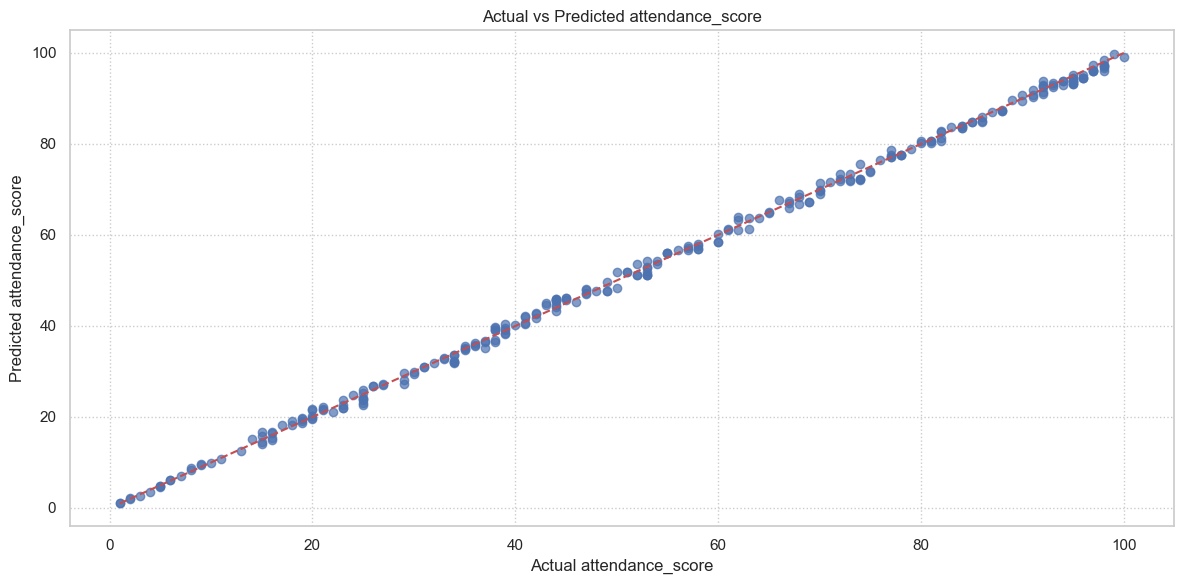

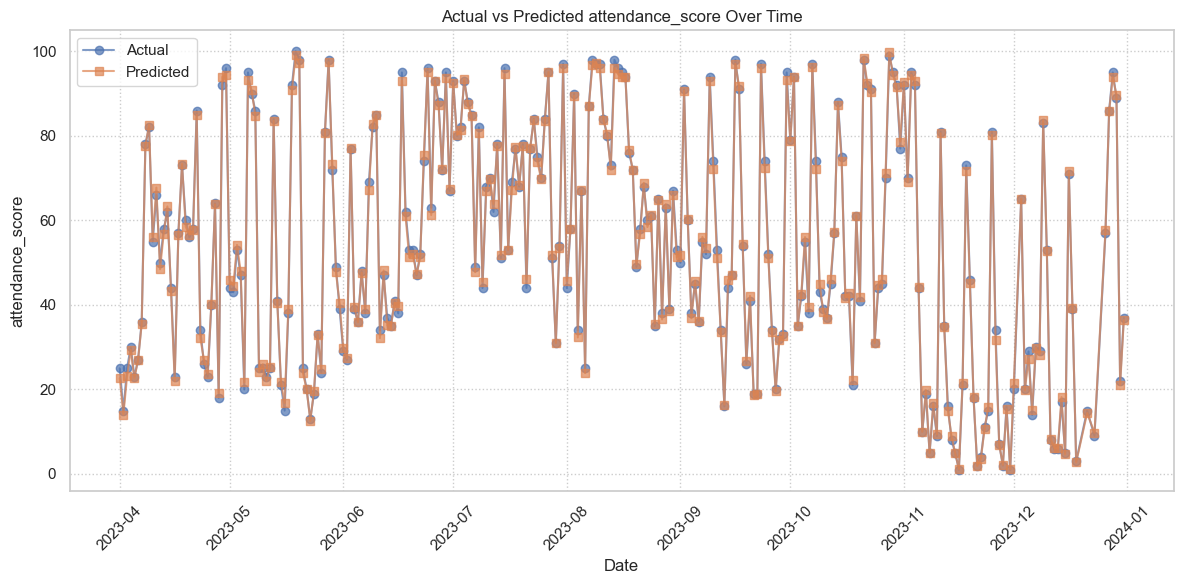

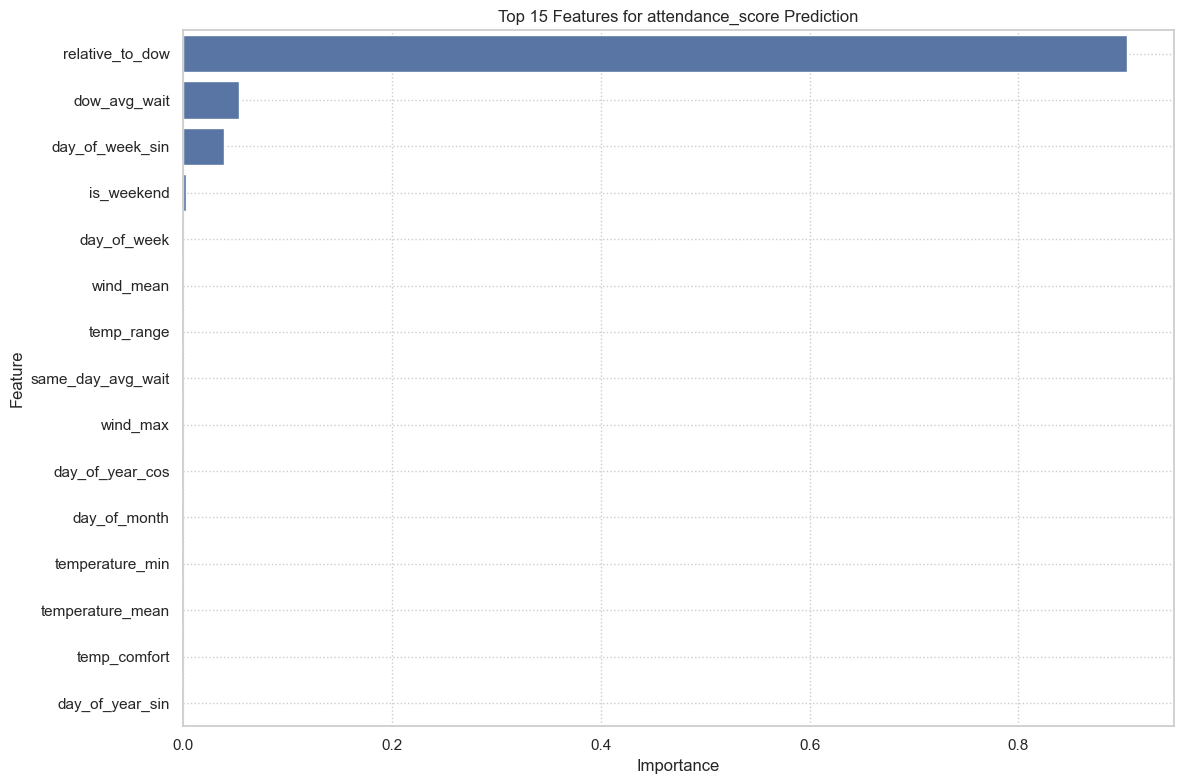


===== PART 2: Using Attendance to Enhance Wait Time Prediction =====
Training on 1257 dates, testing on 269 dates
Starting feature preparation...
Input dataframe shape: (30384, 86)
Total features selected: 68
Features with most missing values:
rain_intensity    22283
temp_bin            661
dtype: int64
Filling 661 missing values in 'temp_bin'
Filling 22283 missing values in 'rain_intensity'
Training data: 22142 samples
Test data: 4200 samples

----- Training Gradient Boosting Model -----

----- Evaluating Base Model -----
Mean Absolute Error (MAE): 2.93 minutes
Root Mean Squared Error (RMSE): 3.95 minutes
R² Score: 0.9129
Mean Absolute Percentage Error (MAPE): 29.26%
MAE for low wait times (<10 min): 3.19 minutes
MAE for medium wait times (10-40 min): 2.84 minutes
MAE for high wait times (>40 min): 3.22 minutes

----- Training Peak Correction Model -----

----- Applying Correction Model -----
Primary Model Metrics:
MAE: 2.93, RMSE: 3.95, R²: 0.9129, MAPE: 29.26%

Corrected Model Metr

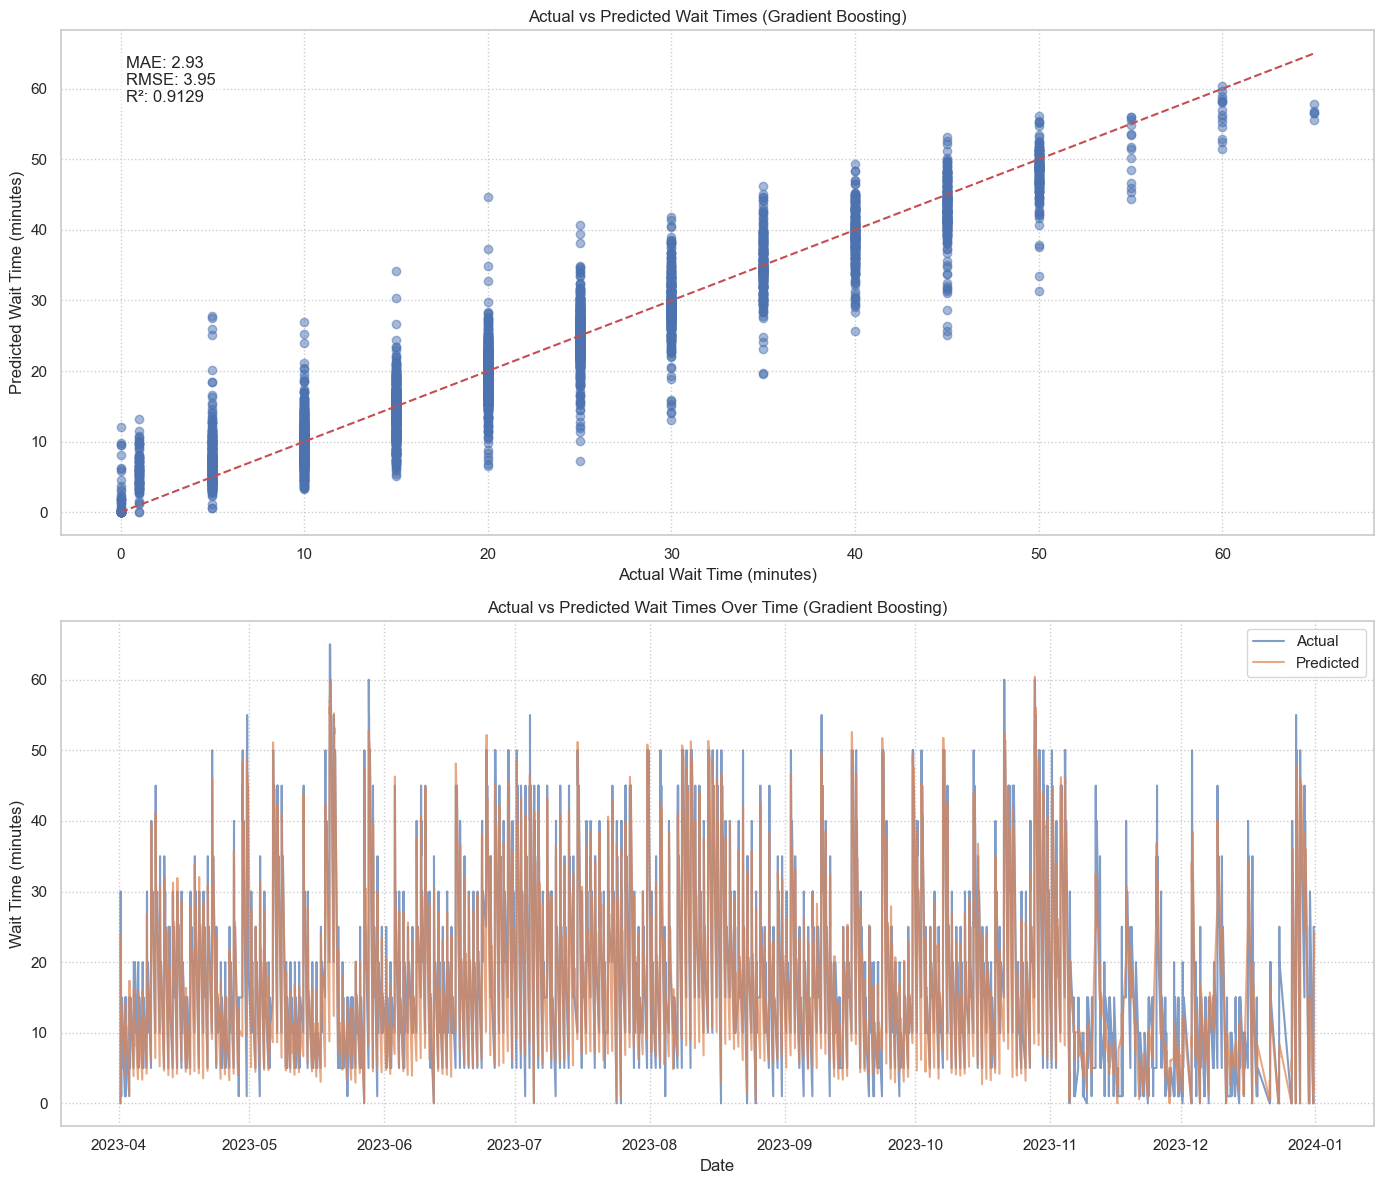

C:\Users\Nevin\AppData\Local\Temp\ipykernel_34300\1340702929.py:53: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  bin_metrics = results_df.groupby('wait_bin').agg({
C:\Users\Nevin\AppData\Local\Temp\ipykernel_34300\1340702929.py:59: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  bin_metrics['Abs Mean Error'] = results_df.groupby('wait_bin')['Error'].apply(lambda x: np.abs(x).mean())


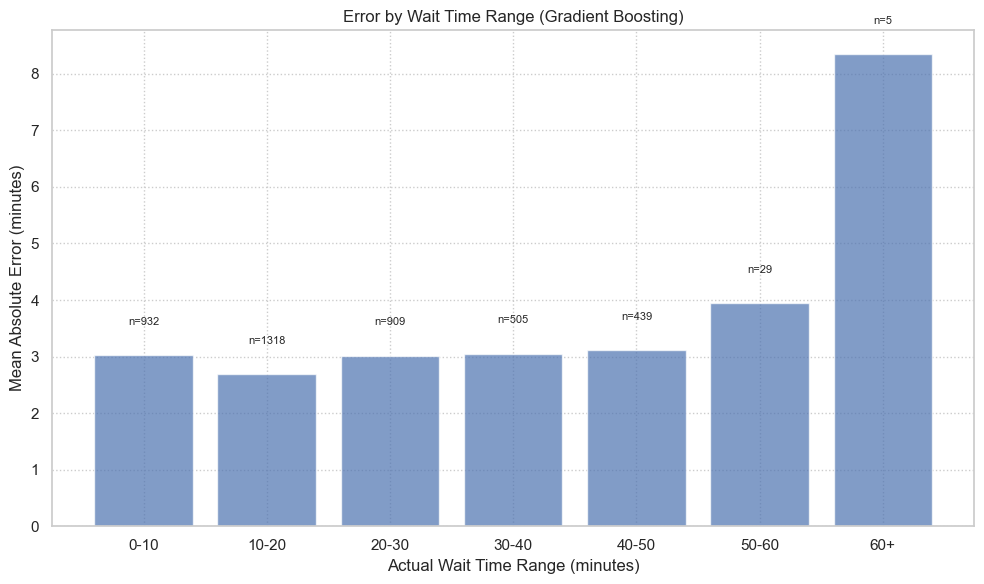

C:\Users\Nevin\AppData\Local\Temp\ipykernel_34300\1340702929.py:84: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  hourly_abs_errors = results_df.groupby('hour').apply(lambda x: np.abs(x['Error']).mean())


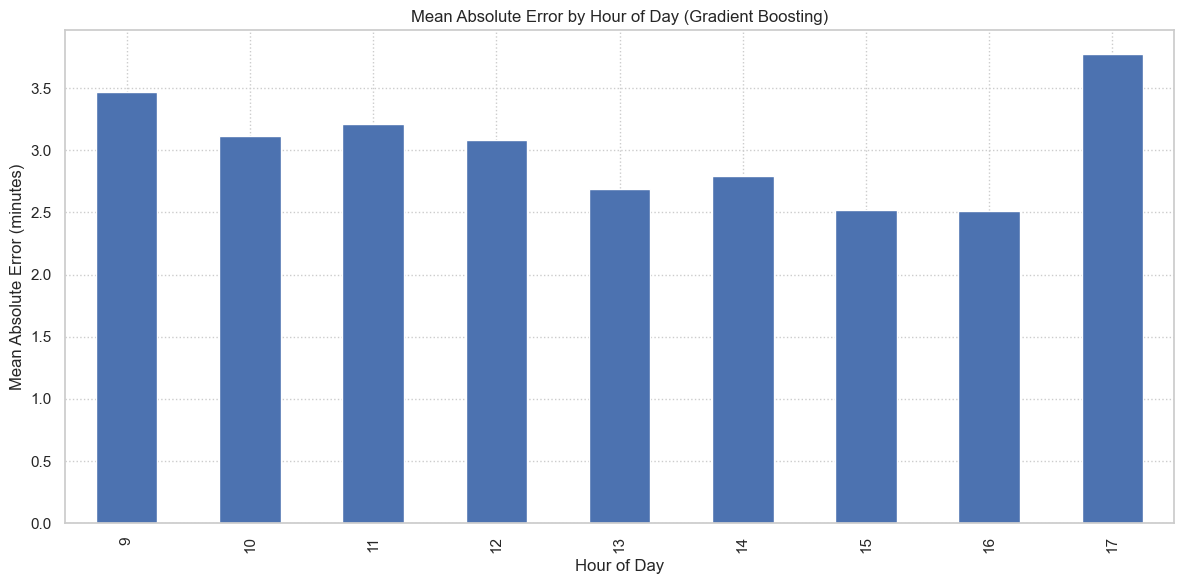

C:\Users\Nevin\AppData\Local\Temp\ipykernel_34300\1340702929.py:103: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_abs_errors = results_df.groupby('day').apply(lambda x: np.abs(x['Error']).mean())


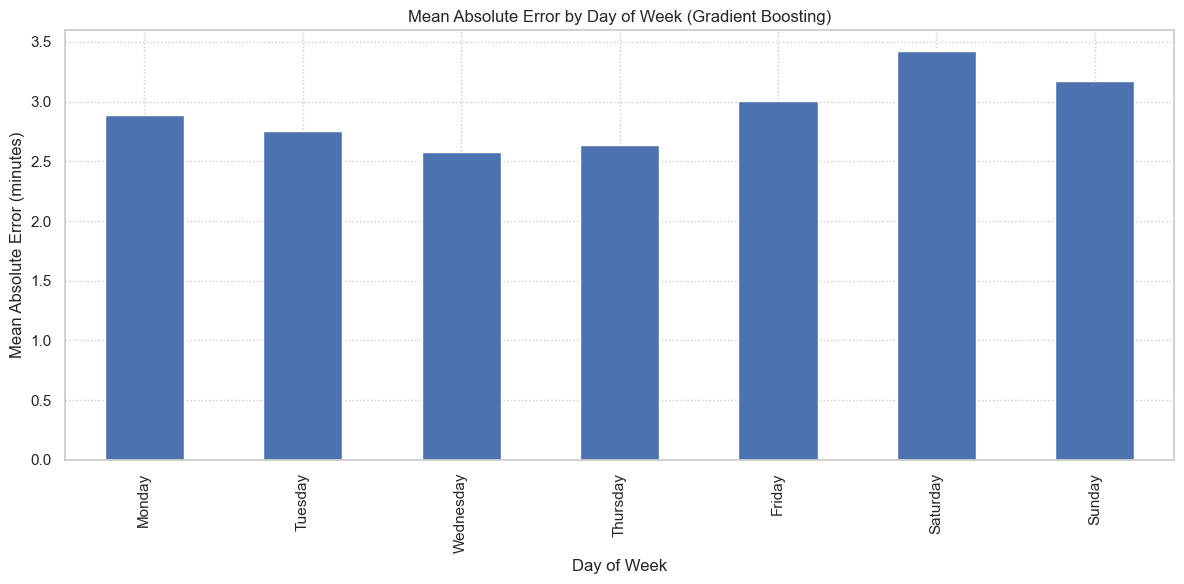


Corrected Model Results:


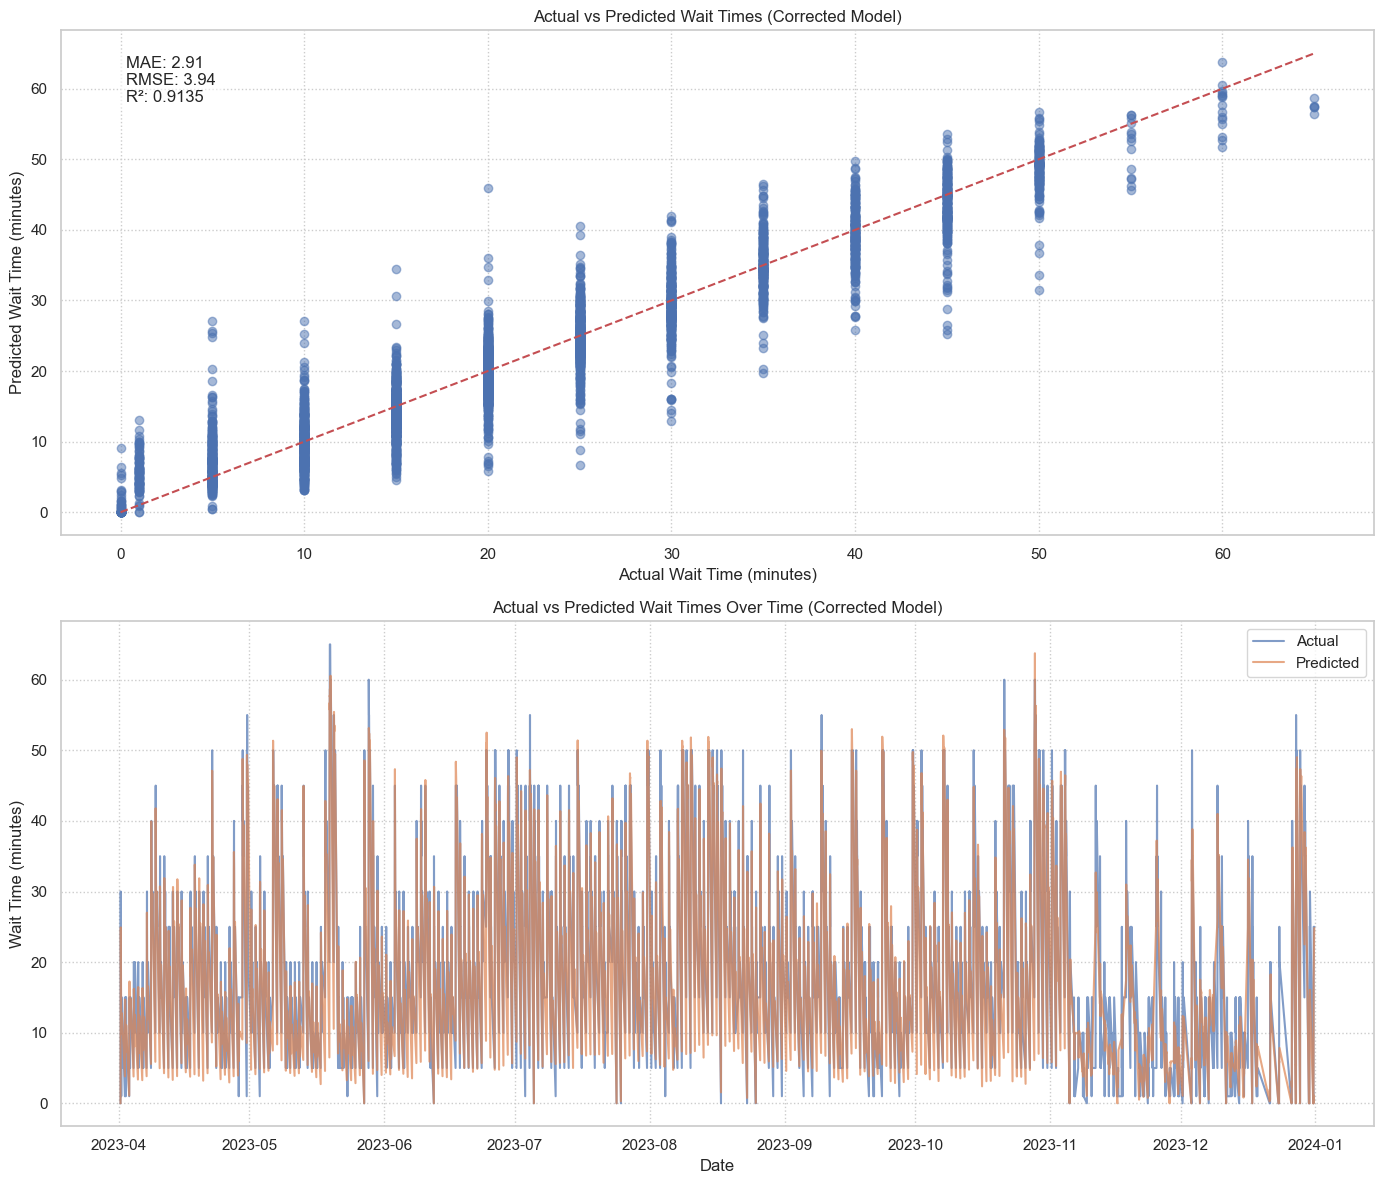

C:\Users\Nevin\AppData\Local\Temp\ipykernel_34300\1340702929.py:53: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  bin_metrics = results_df.groupby('wait_bin').agg({
C:\Users\Nevin\AppData\Local\Temp\ipykernel_34300\1340702929.py:59: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  bin_metrics['Abs Mean Error'] = results_df.groupby('wait_bin')['Error'].apply(lambda x: np.abs(x).mean())


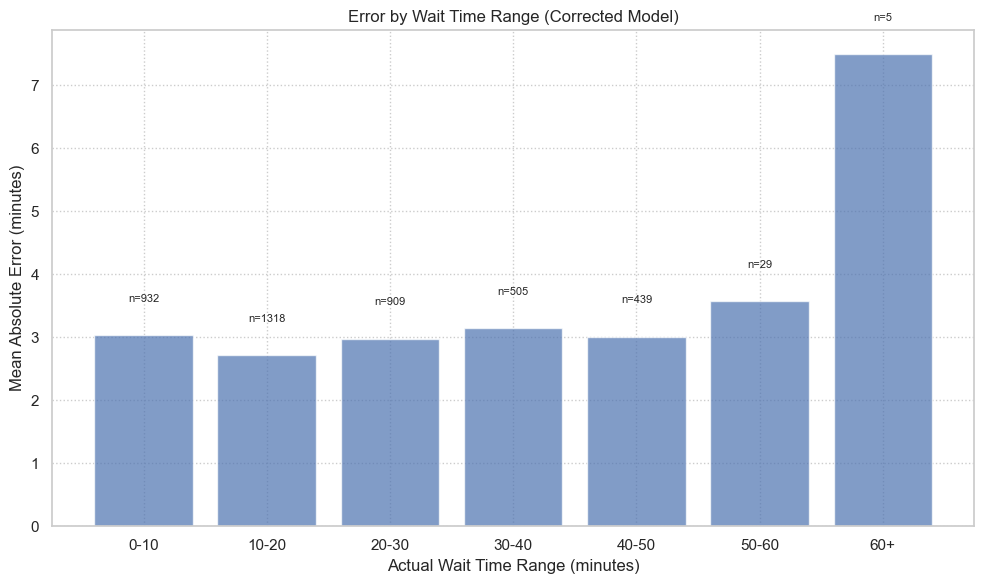

C:\Users\Nevin\AppData\Local\Temp\ipykernel_34300\1340702929.py:84: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  hourly_abs_errors = results_df.groupby('hour').apply(lambda x: np.abs(x['Error']).mean())


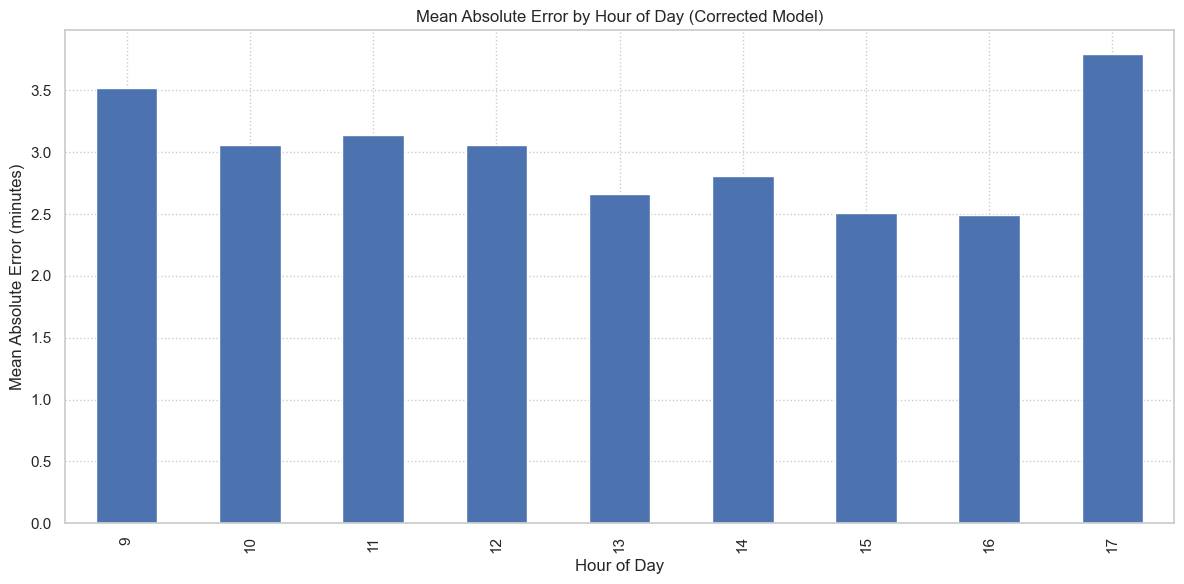

C:\Users\Nevin\AppData\Local\Temp\ipykernel_34300\1340702929.py:103: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_abs_errors = results_df.groupby('day').apply(lambda x: np.abs(x['Error']).mean())


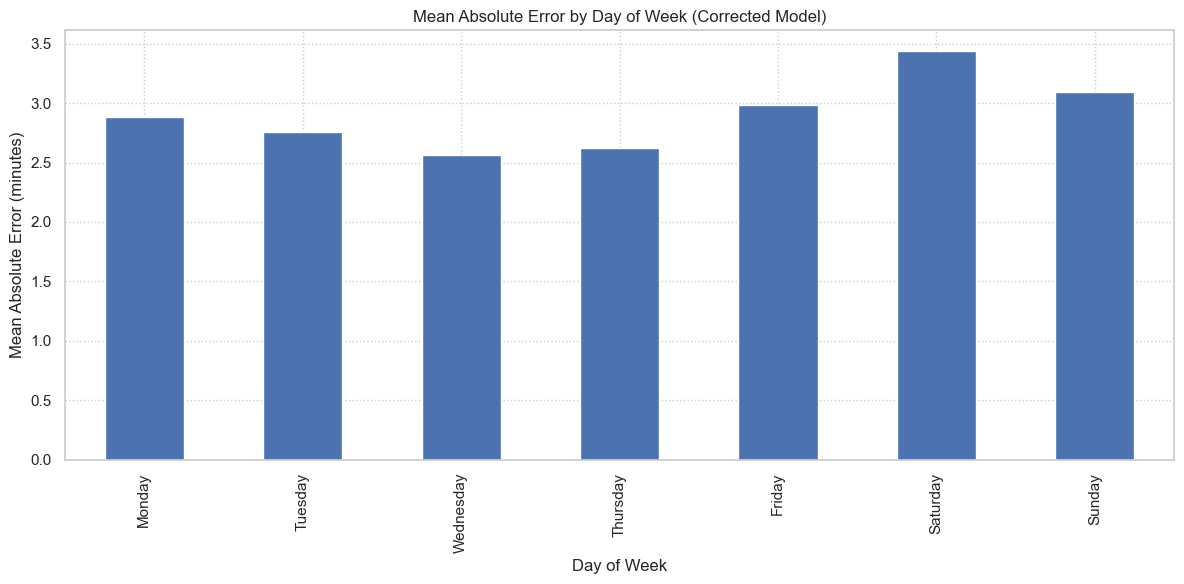


Ensemble Model Results:


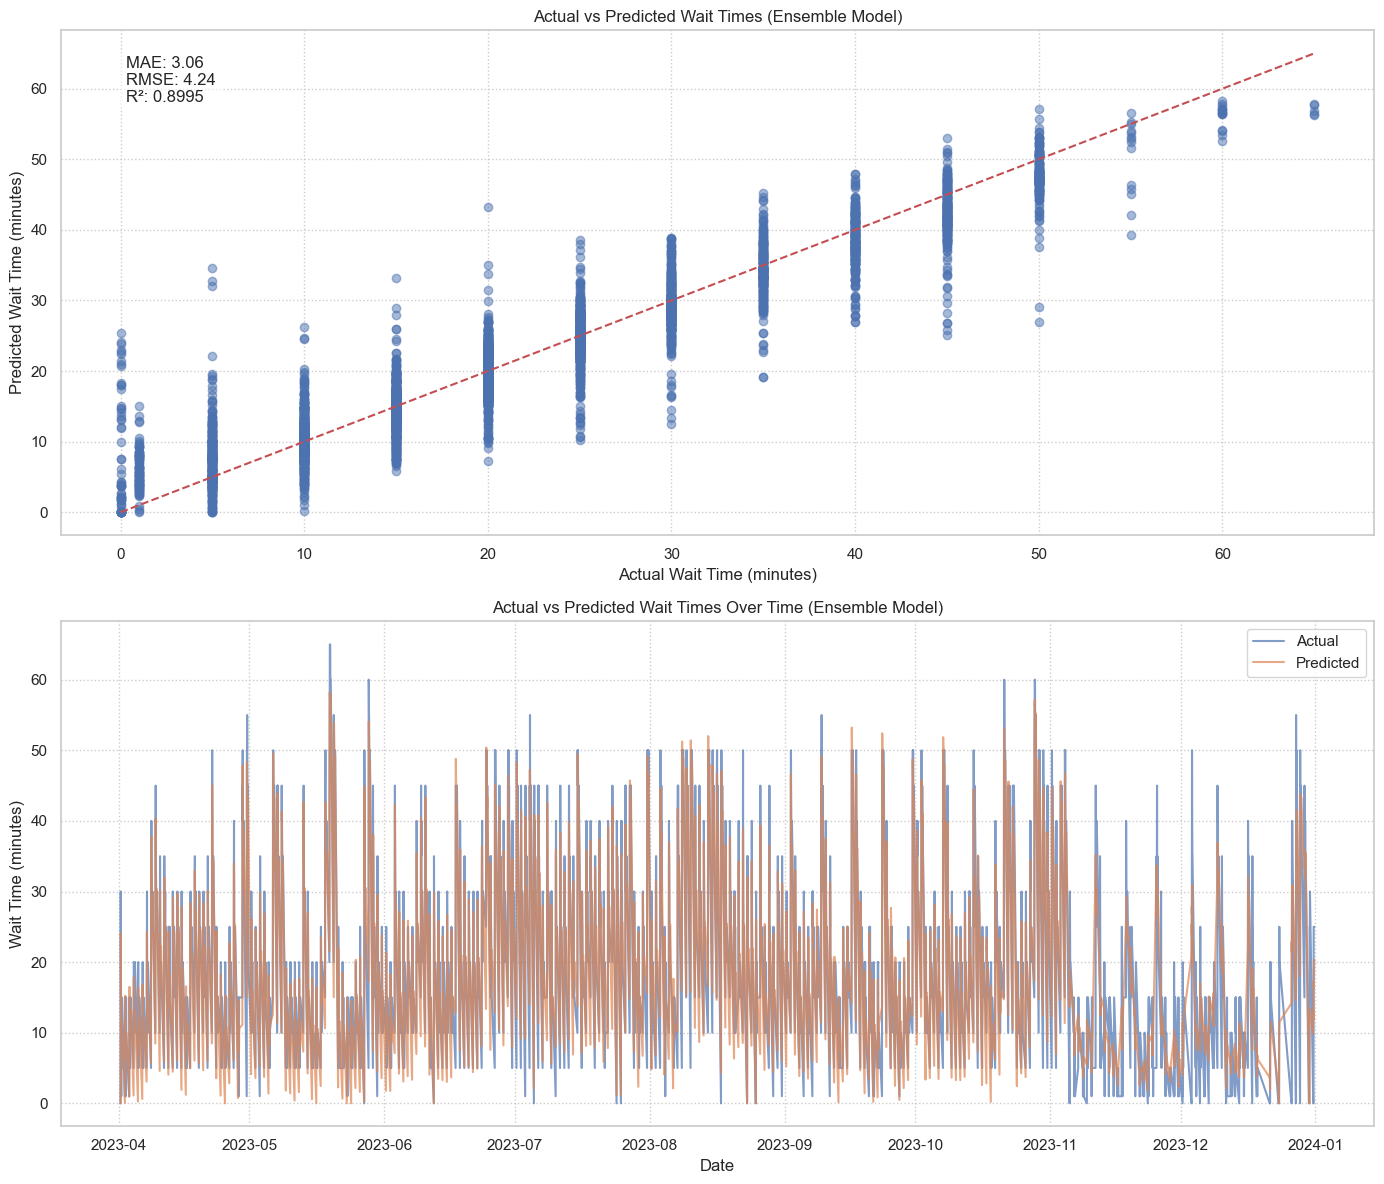

C:\Users\Nevin\AppData\Local\Temp\ipykernel_34300\1340702929.py:53: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  bin_metrics = results_df.groupby('wait_bin').agg({
C:\Users\Nevin\AppData\Local\Temp\ipykernel_34300\1340702929.py:59: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  bin_metrics['Abs Mean Error'] = results_df.groupby('wait_bin')['Error'].apply(lambda x: np.abs(x).mean())


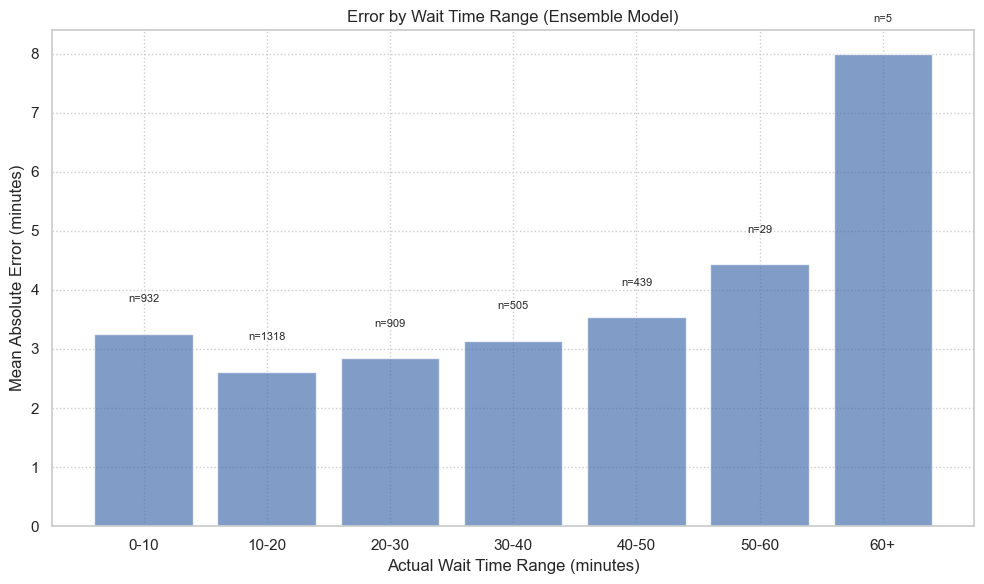

C:\Users\Nevin\AppData\Local\Temp\ipykernel_34300\1340702929.py:84: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  hourly_abs_errors = results_df.groupby('hour').apply(lambda x: np.abs(x['Error']).mean())


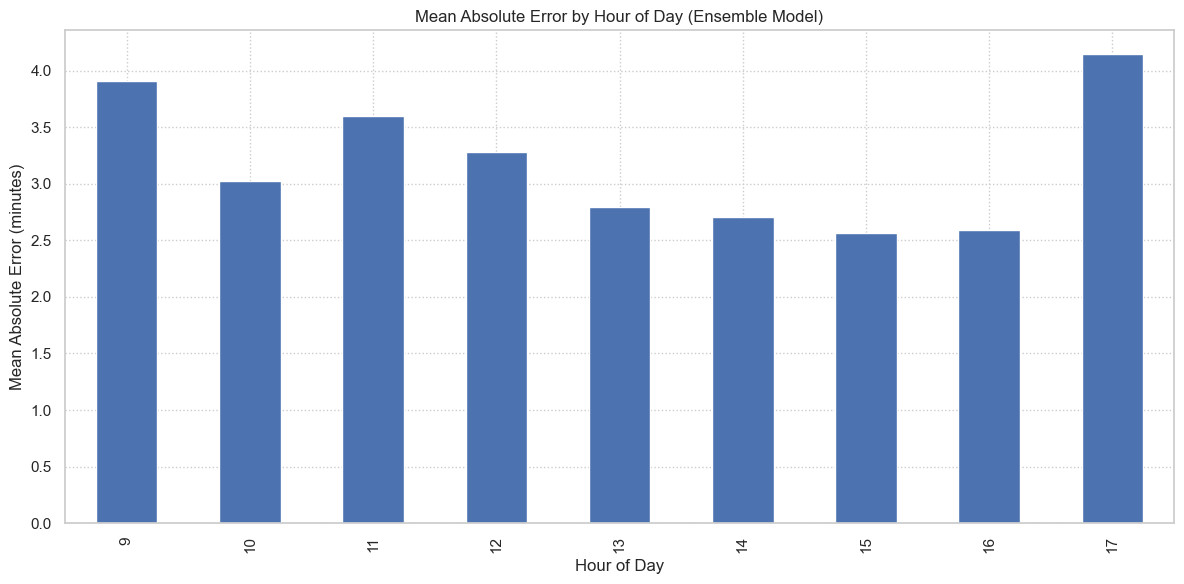

C:\Users\Nevin\AppData\Local\Temp\ipykernel_34300\1340702929.py:103: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_abs_errors = results_df.groupby('day').apply(lambda x: np.abs(x['Error']).mean())


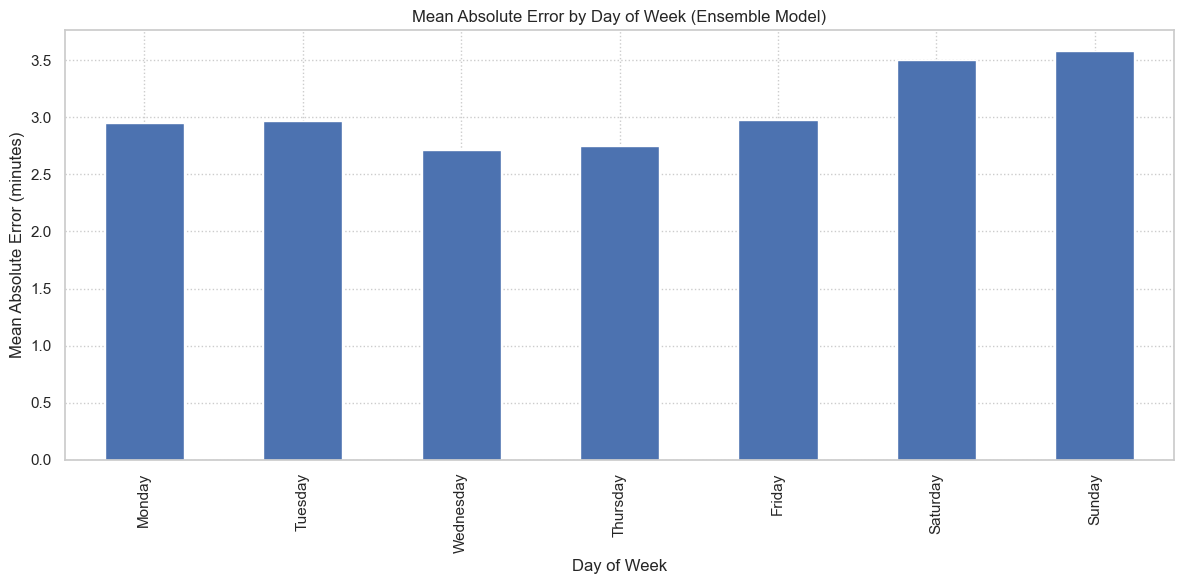


Best model based on MAE: Corrected GB
Identified 183 special dates (≥90.0th percentile):
  2017-05-25: High attendance day (96%): 43.0min avg wait
  2017-05-26: High attendance day (100%): 62.5min avg wait
  2017-06-04: High attendance day (91%): 37.0min avg wait
  2017-07-22: High attendance day (97%): 45.0min avg wait
  2017-08-14: High attendance day (98%): 48.4min avg wait
  2017-08-15: High attendance day (91%): 36.9min avg wait
  2017-09-23: High attendance day (97%): 43.4min avg wait
  2017-10-07: High attendance day (95%): 40.9min avg wait
  2017-10-21: High attendance day (94%): 40.3min avg wait
  2017-10-28: High attendance day (98%): 47.3min avg wait
  ... plus 173 more

Saved integrated model to models/silver star_integrated_model.joblib

===== Demonstrating Future Wait Time Prediction for silver star =====
Predicting attendance for future dates...
Starting feature preparation...
Input dataframe shape: (84, 41)
Total features selected: 33
Making wait time predictions...
Er

Traceback (most recent call last):
  File "C:\Users\Nevin\AppData\Local\Temp\ipykernel_34300\1098225118.py", line 94, in <module>
    future_predictions = demo_future_prediction(ride_results, ride_name)
                         ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\Nevin\AppData\Local\Temp\ipykernel_34300\1098225118.py", line 47, in demo_future_prediction
    predictions = predict_future_wait_times(
                  ^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\Nevin\AppData\Local\Temp\ipykernel_34300\3650375753.py", line 101, in predict_future_wait_times
    predictions = apply_correction_model(primary_model, correction_model, feature_df)
                  ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\Nevin\AppData\Local\Temp\ipykernel_34300\2899288265.py", line 6, in apply_correction_model
    y_pred_primary = primary_model.predict(X_test)
                     ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Nevin\anacond

Loaded data shape: (103081, 11)
Number of fully closed days: 418
Sample of fully closed days: Index([2017-09-10, 2017-10-14, 2017-11-06, 2017-11-07, 2017-11-08, 2017-11-09,
       2017-11-10, 2017-11-11, 2017-11-12, 2017-11-13],
      dtype='object', name='timestamp')
Number of days with zero wait times: 450
Sample of zero wait time days: Index([2017-06-06, 2017-08-31, 2017-09-12, 2017-09-13, 2017-09-14, 2017-09-19,
       2017-09-20, 2017-10-06, 2017-10-08, 2017-10-23],
      dtype='object', name='timestamp')
Data shape after removing closed and zero wait days: (61422, 11)
Data shape after filtering to operating hours: (22290, 11)

===== PART 1: Training Attendance Prediction Model =====
Calculated daily attendance metrics for 1280 days
Training attendance prediction model for attendance_score...
Training data: 933 days, Test data: 186 days
Test MAE: 0.78
Test RMSE: 1.00
Test R²: 0.9988


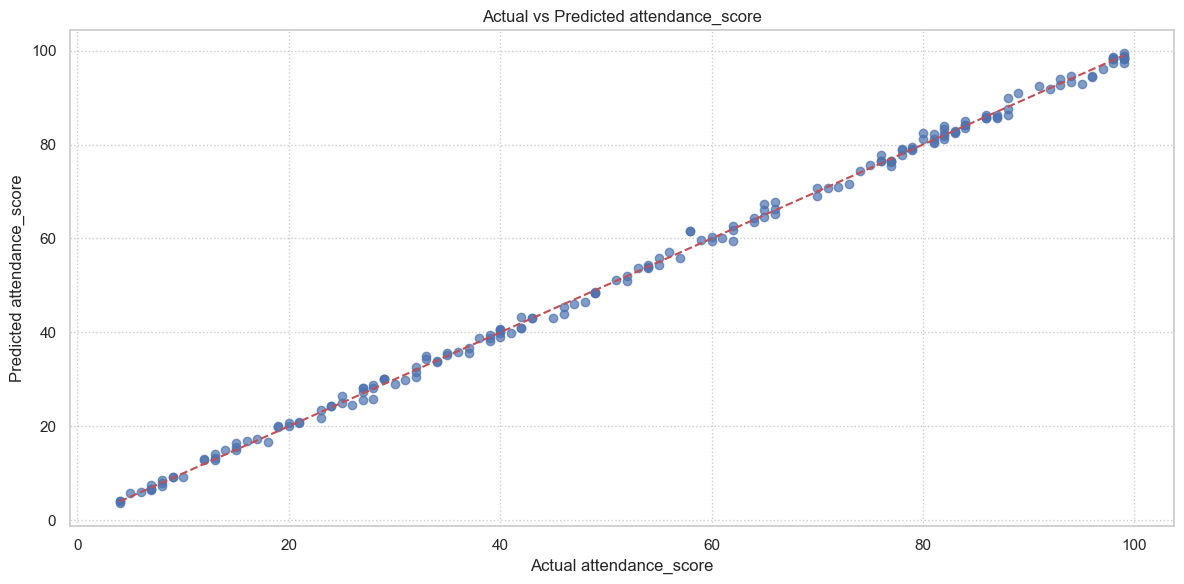

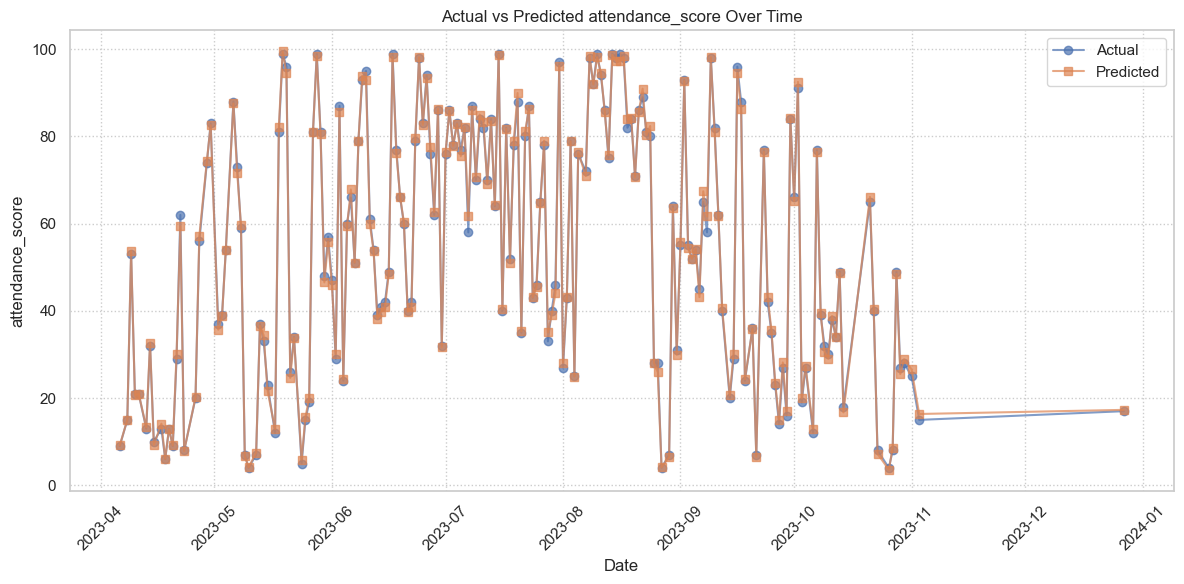

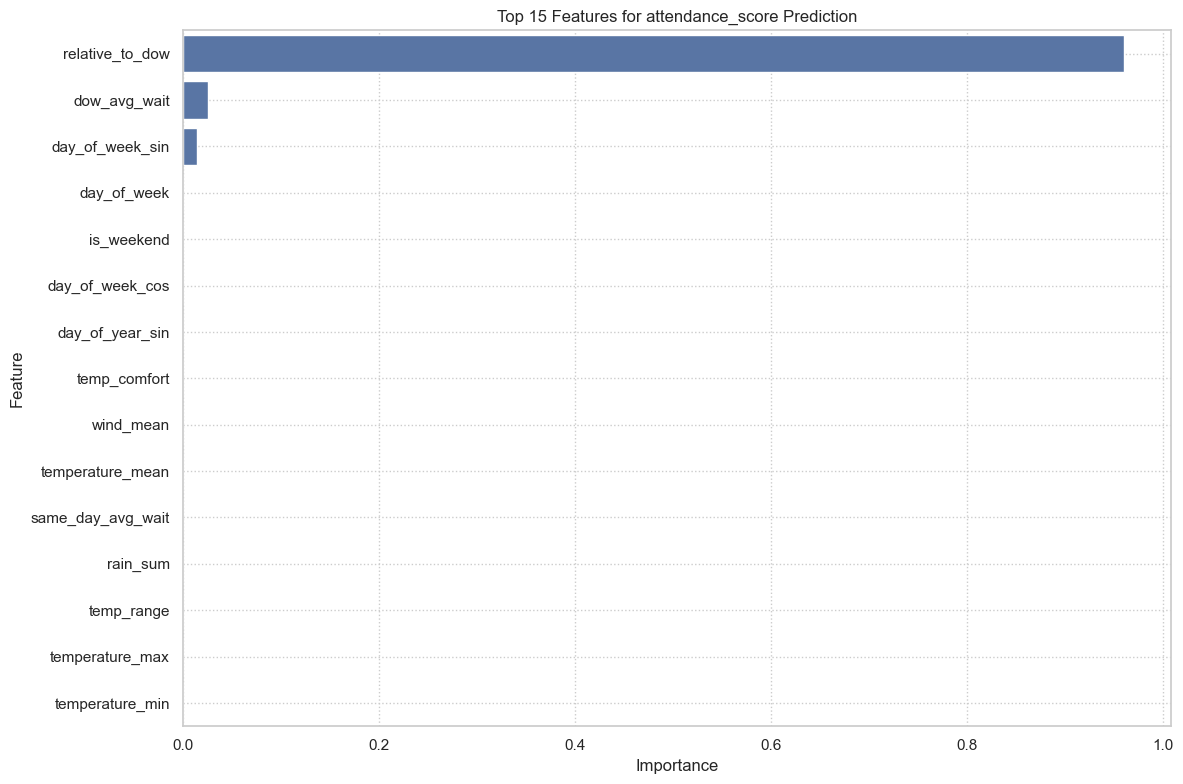


===== PART 2: Using Attendance to Enhance Wait Time Prediction =====
Training on 933 dates, testing on 186 dates
Starting feature preparation...
Input dataframe shape: (22290, 86)
Total features selected: 68
Features with most missing values:
rain_intensity    17697
temp_bin            252
dtype: int64
Filling 252 missing values in 'temp_bin'
Filling 17697 missing values in 'rain_intensity'
Training data: 16808 samples
Test data: 2972 samples

----- Training Gradient Boosting Model -----

----- Evaluating Base Model -----
Mean Absolute Error (MAE): 3.67 minutes
Root Mean Squared Error (RMSE): 5.08 minutes
R² Score: 0.9192
Mean Absolute Percentage Error (MAPE): 66.93%
MAE for low wait times (<10 min): 2.59 minutes
MAE for medium wait times (10-40 min): 4.13 minutes
MAE for high wait times (>40 min): 4.05 minutes

----- Training Peak Correction Model -----

----- Applying Correction Model -----
Primary Model Metrics:
MAE: 3.67, RMSE: 5.08, R²: 0.9192, MAPE: 66.93%

Corrected Model Metri

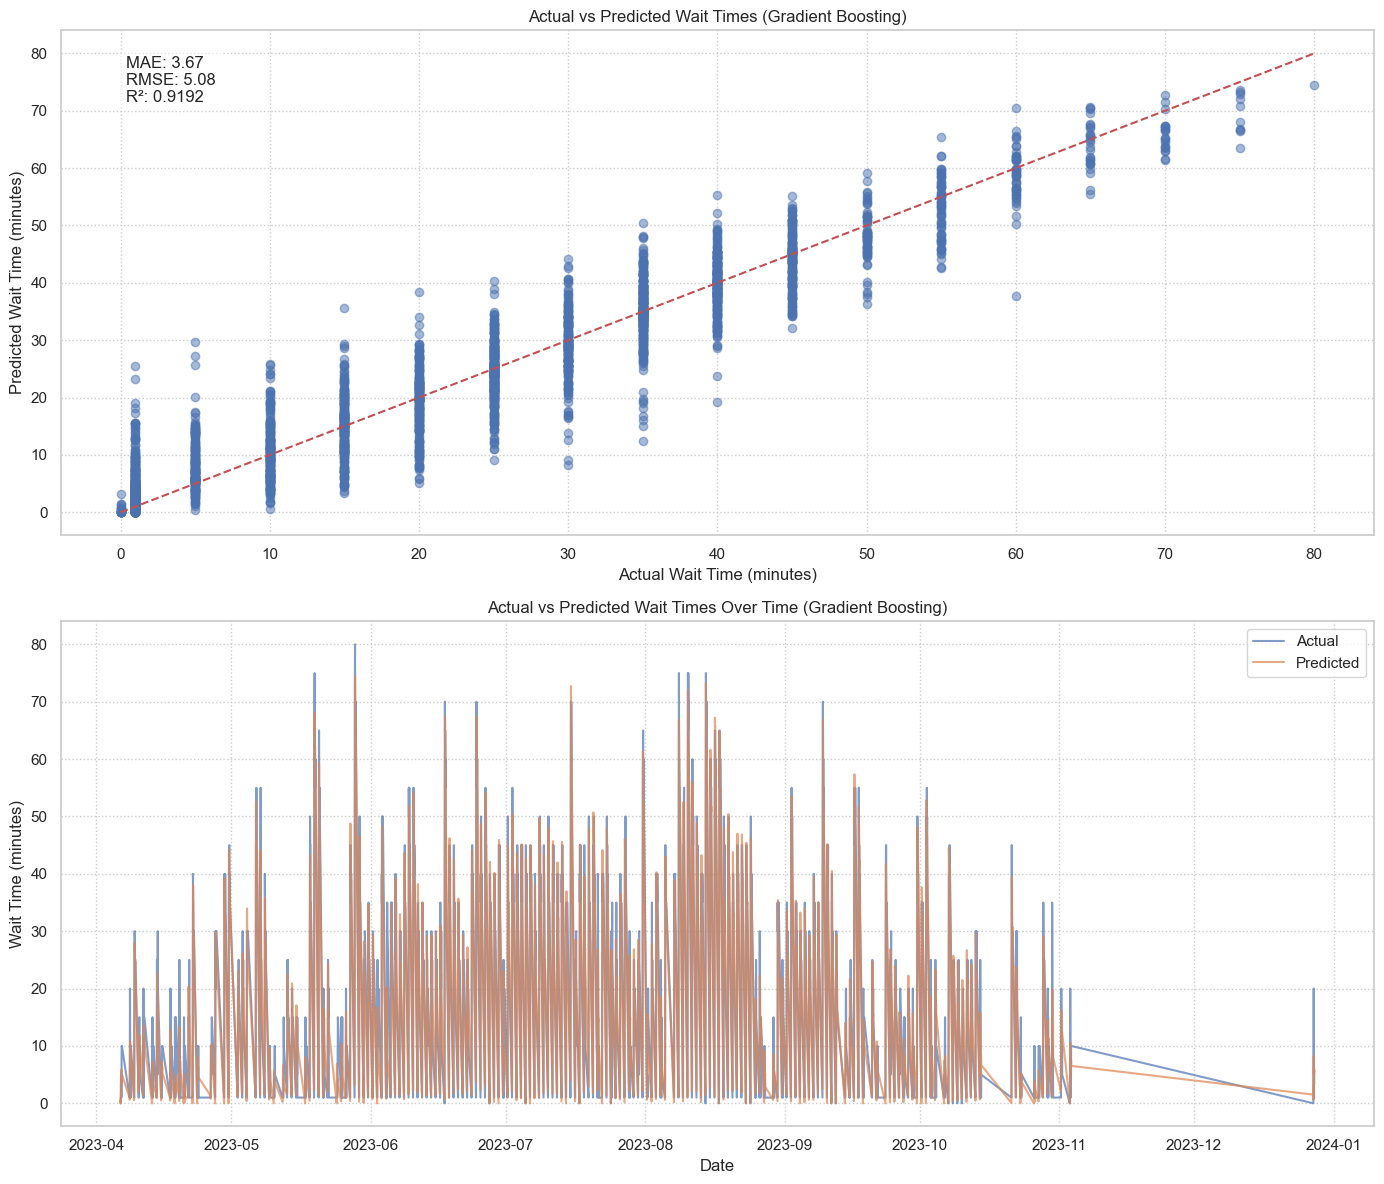

C:\Users\Nevin\AppData\Local\Temp\ipykernel_34300\1340702929.py:53: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  bin_metrics = results_df.groupby('wait_bin').agg({
C:\Users\Nevin\AppData\Local\Temp\ipykernel_34300\1340702929.py:59: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  bin_metrics['Abs Mean Error'] = results_df.groupby('wait_bin')['Error'].apply(lambda x: np.abs(x).mean())


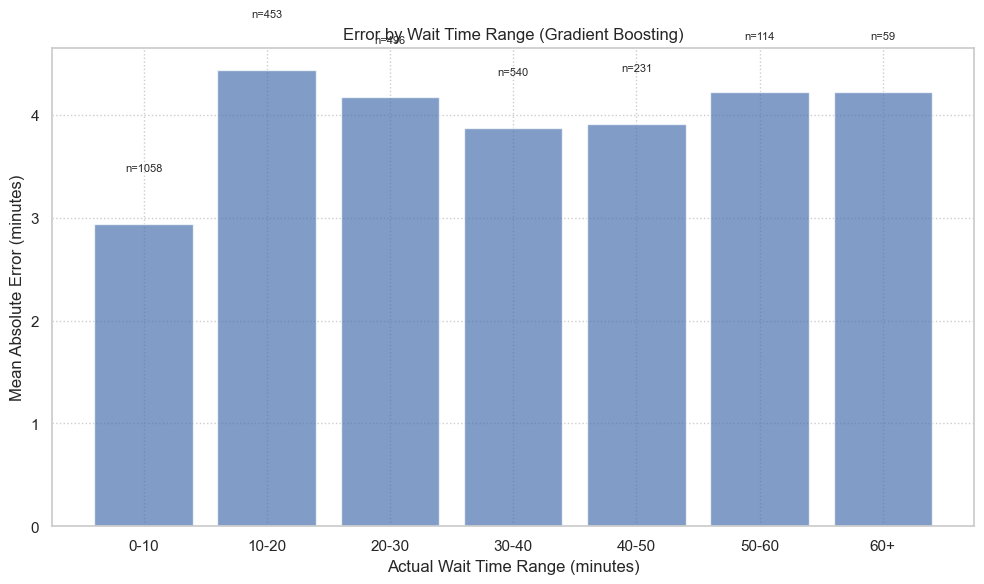

C:\Users\Nevin\AppData\Local\Temp\ipykernel_34300\1340702929.py:84: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  hourly_abs_errors = results_df.groupby('hour').apply(lambda x: np.abs(x['Error']).mean())


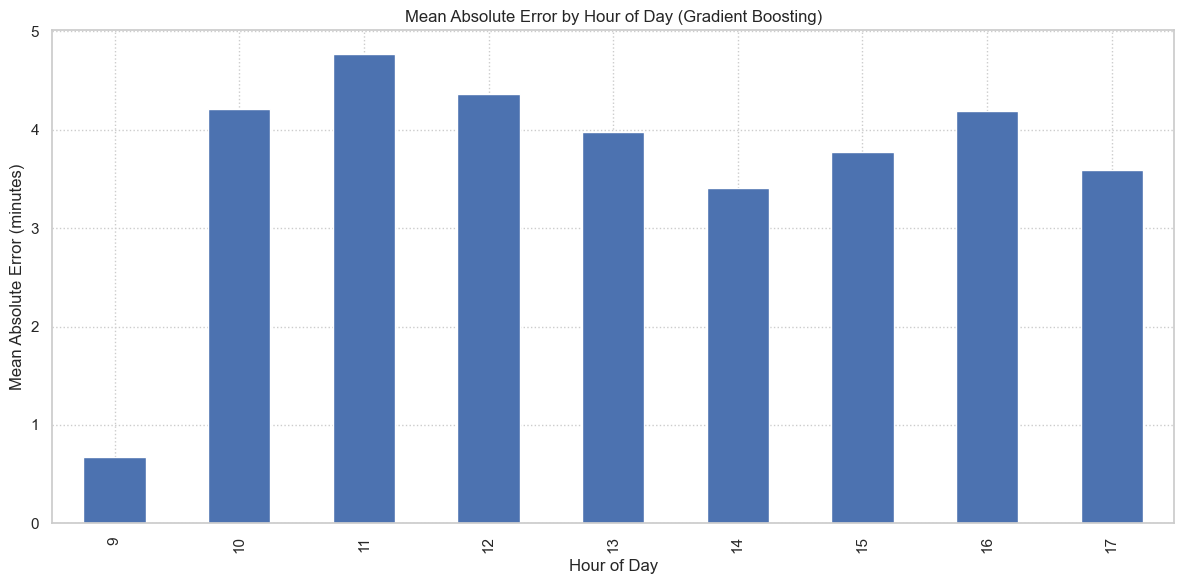

C:\Users\Nevin\AppData\Local\Temp\ipykernel_34300\1340702929.py:103: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_abs_errors = results_df.groupby('day').apply(lambda x: np.abs(x['Error']).mean())


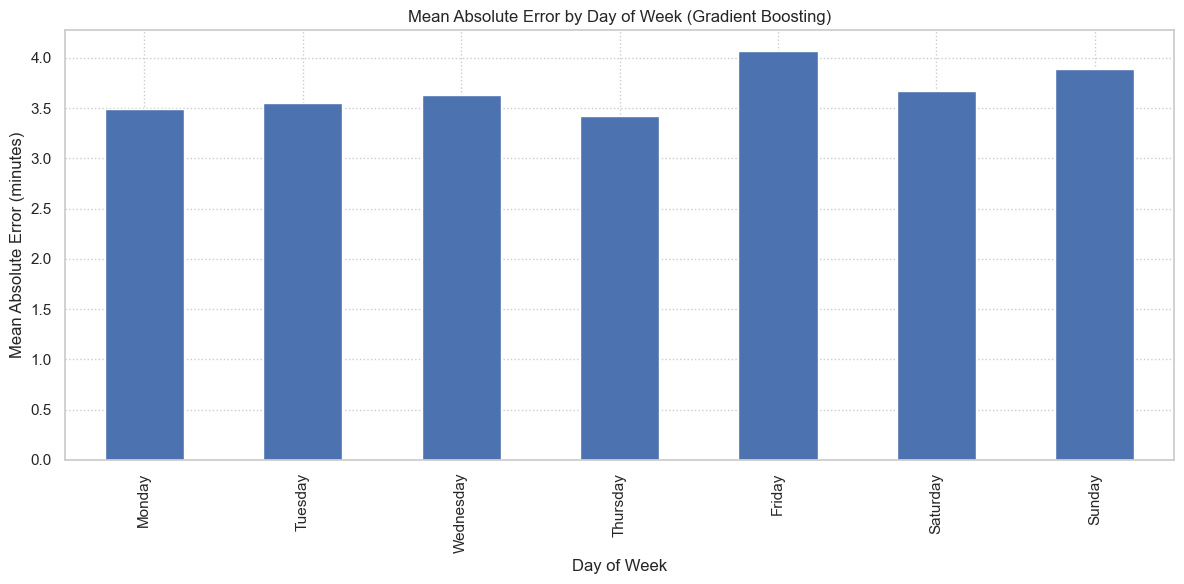


Corrected Model Results:


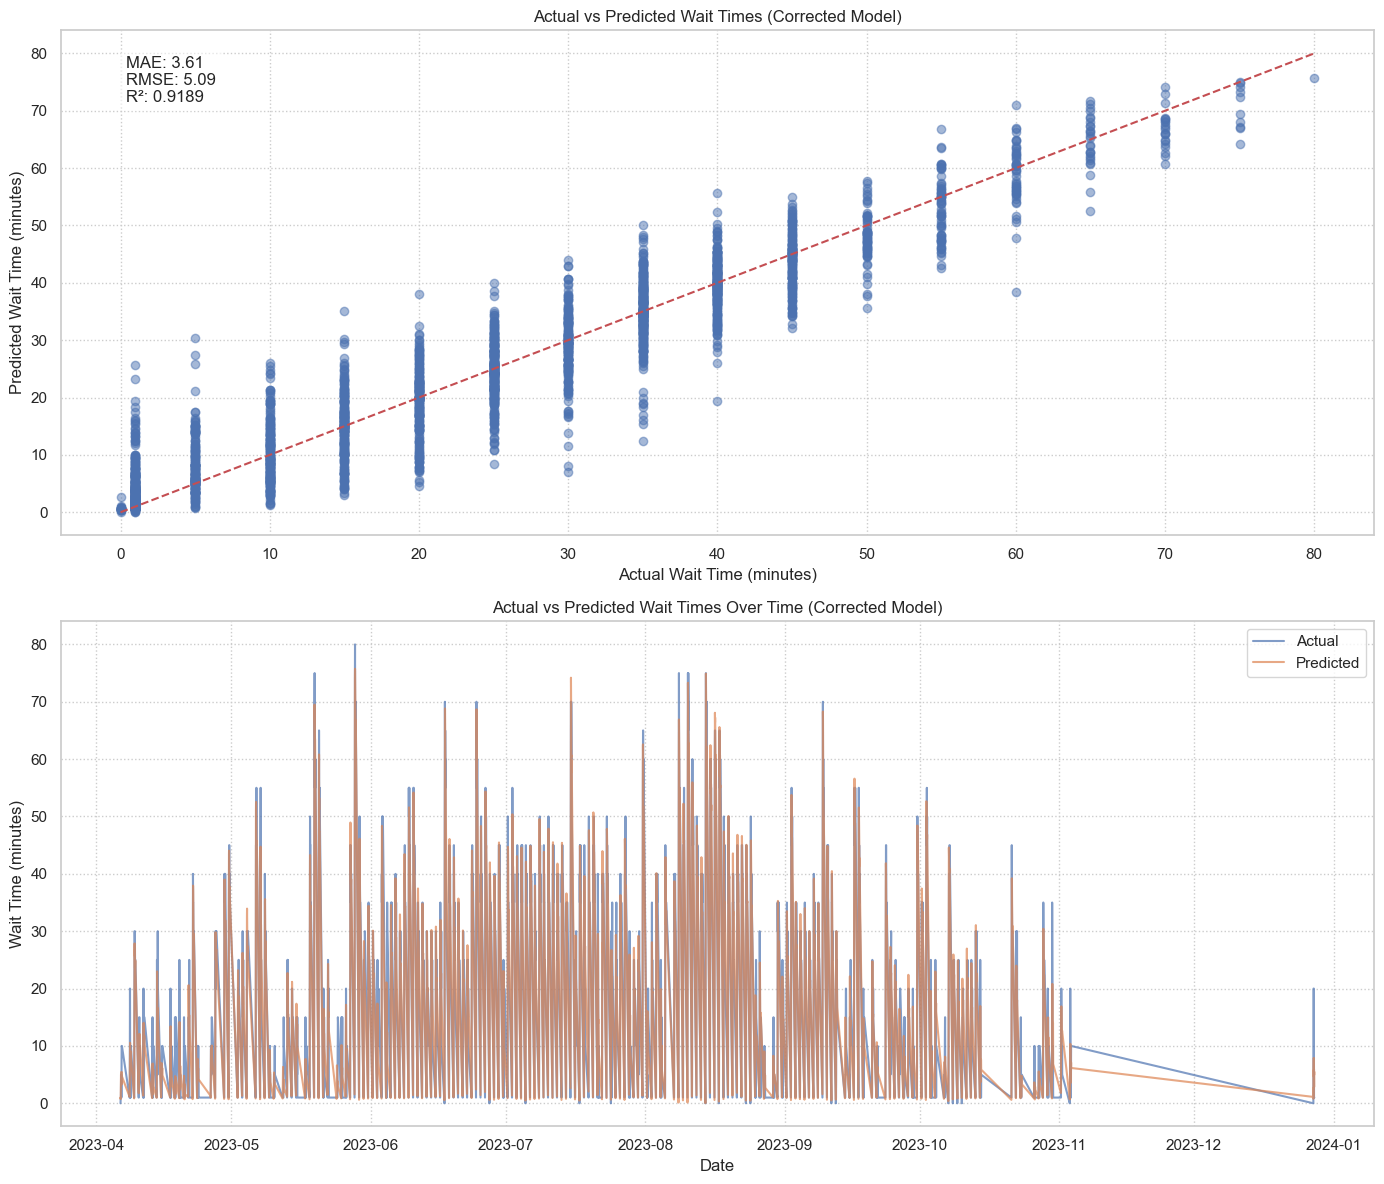

C:\Users\Nevin\AppData\Local\Temp\ipykernel_34300\1340702929.py:53: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  bin_metrics = results_df.groupby('wait_bin').agg({
C:\Users\Nevin\AppData\Local\Temp\ipykernel_34300\1340702929.py:59: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  bin_metrics['Abs Mean Error'] = results_df.groupby('wait_bin')['Error'].apply(lambda x: np.abs(x).mean())


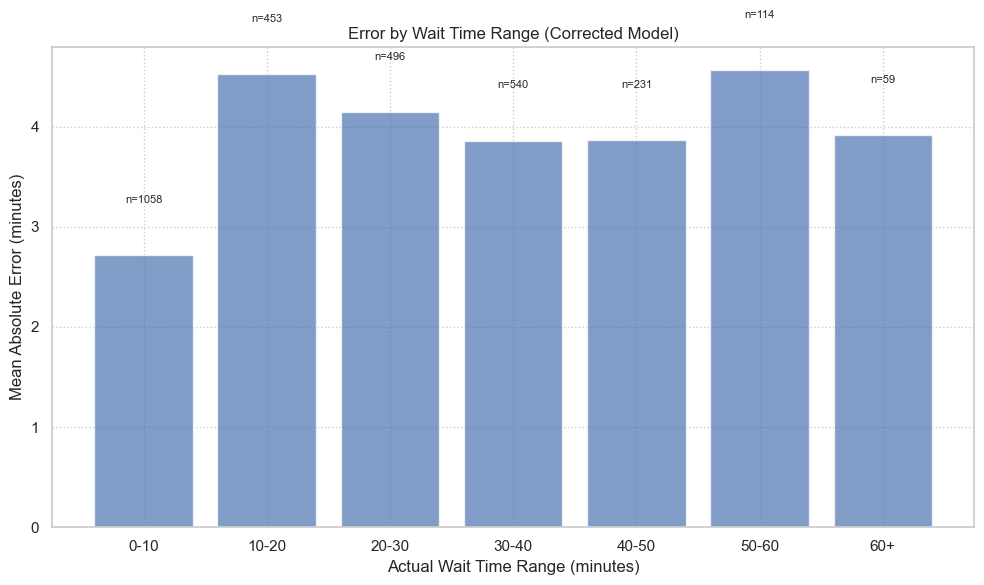

C:\Users\Nevin\AppData\Local\Temp\ipykernel_34300\1340702929.py:84: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  hourly_abs_errors = results_df.groupby('hour').apply(lambda x: np.abs(x['Error']).mean())


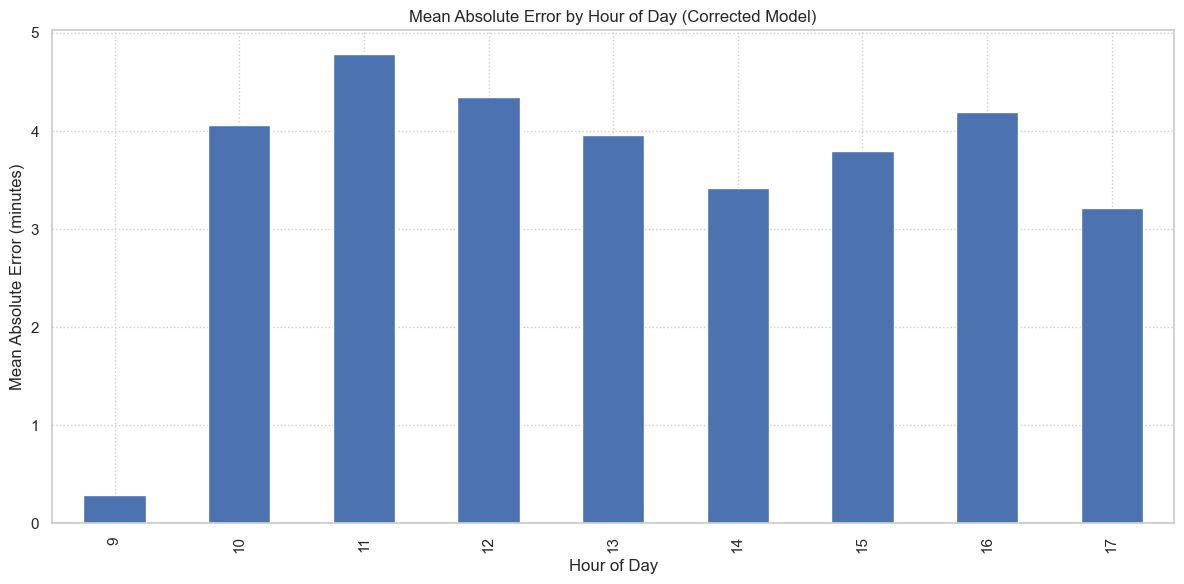

C:\Users\Nevin\AppData\Local\Temp\ipykernel_34300\1340702929.py:103: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_abs_errors = results_df.groupby('day').apply(lambda x: np.abs(x['Error']).mean())


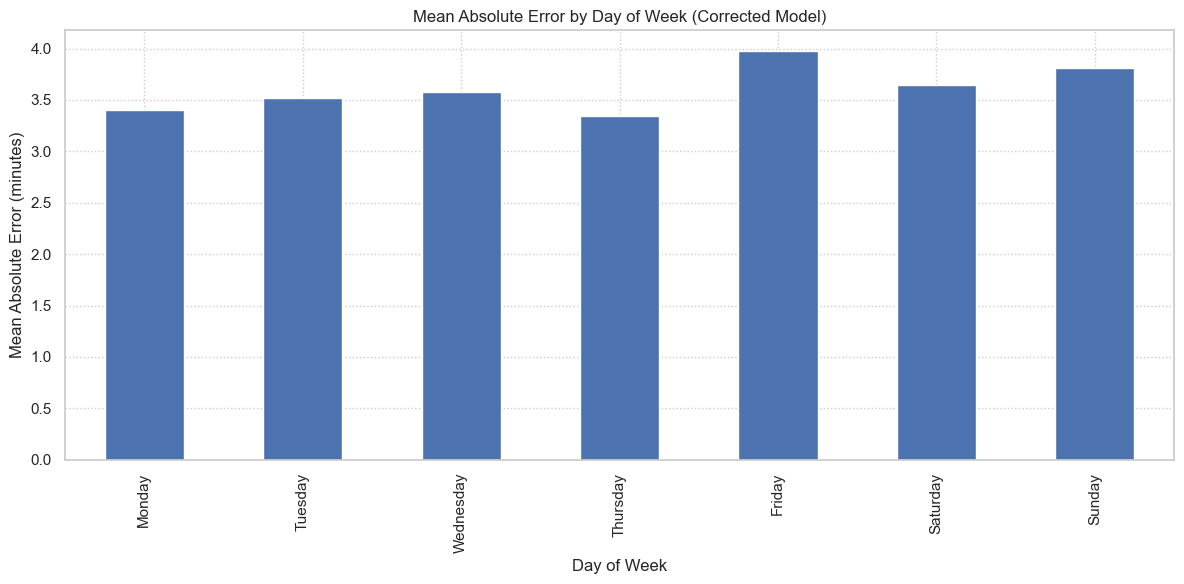


Ensemble Model Results:


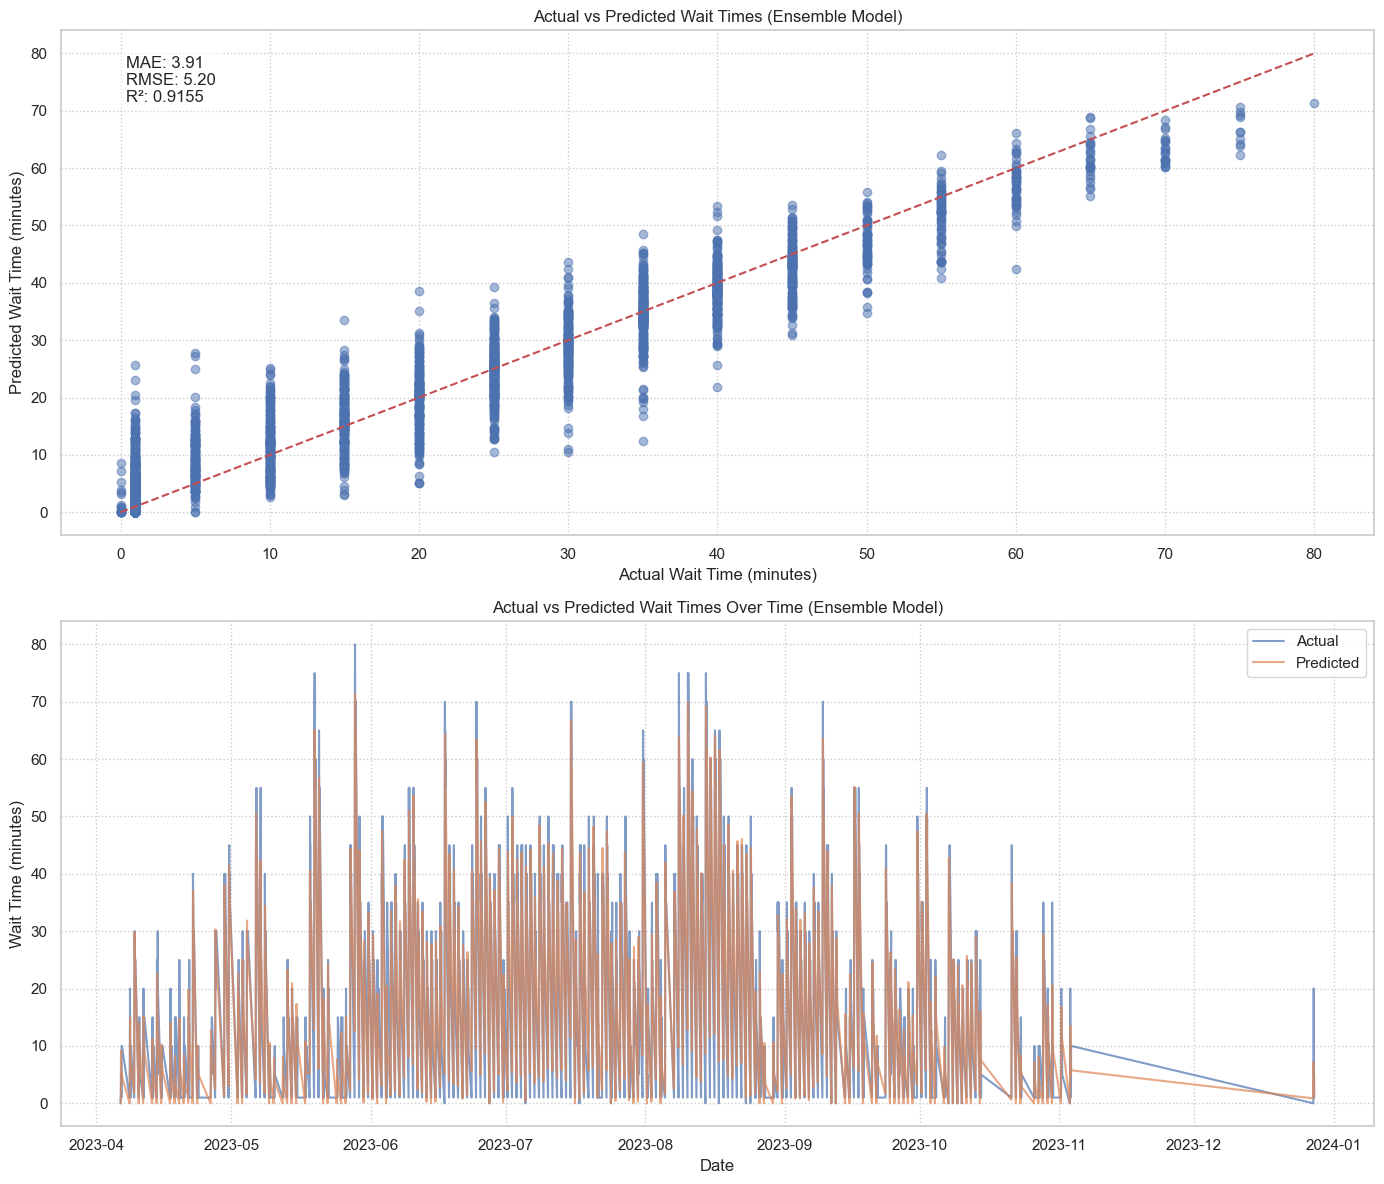

C:\Users\Nevin\AppData\Local\Temp\ipykernel_34300\1340702929.py:53: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  bin_metrics = results_df.groupby('wait_bin').agg({
C:\Users\Nevin\AppData\Local\Temp\ipykernel_34300\1340702929.py:59: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  bin_metrics['Abs Mean Error'] = results_df.groupby('wait_bin')['Error'].apply(lambda x: np.abs(x).mean())


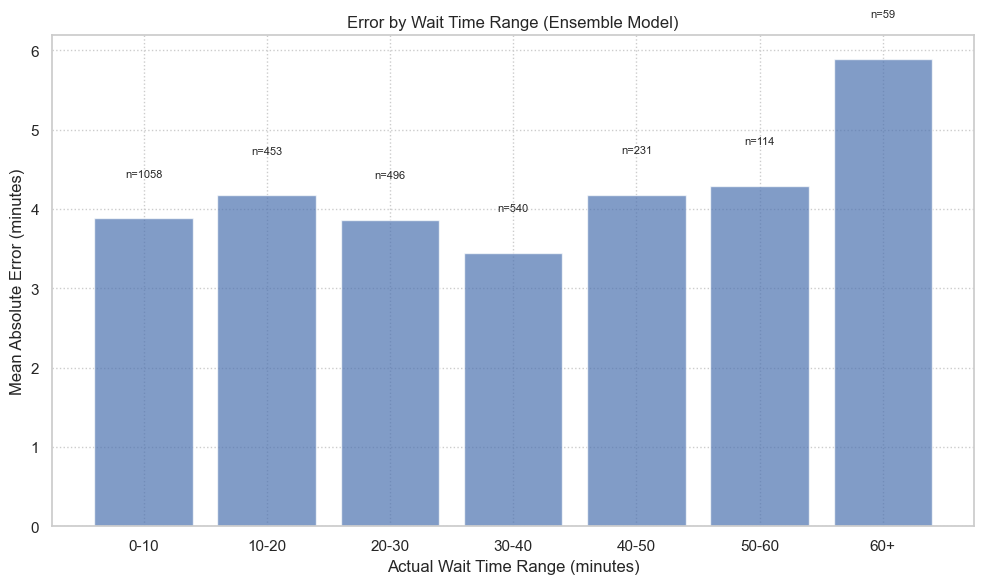

C:\Users\Nevin\AppData\Local\Temp\ipykernel_34300\1340702929.py:84: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  hourly_abs_errors = results_df.groupby('hour').apply(lambda x: np.abs(x['Error']).mean())


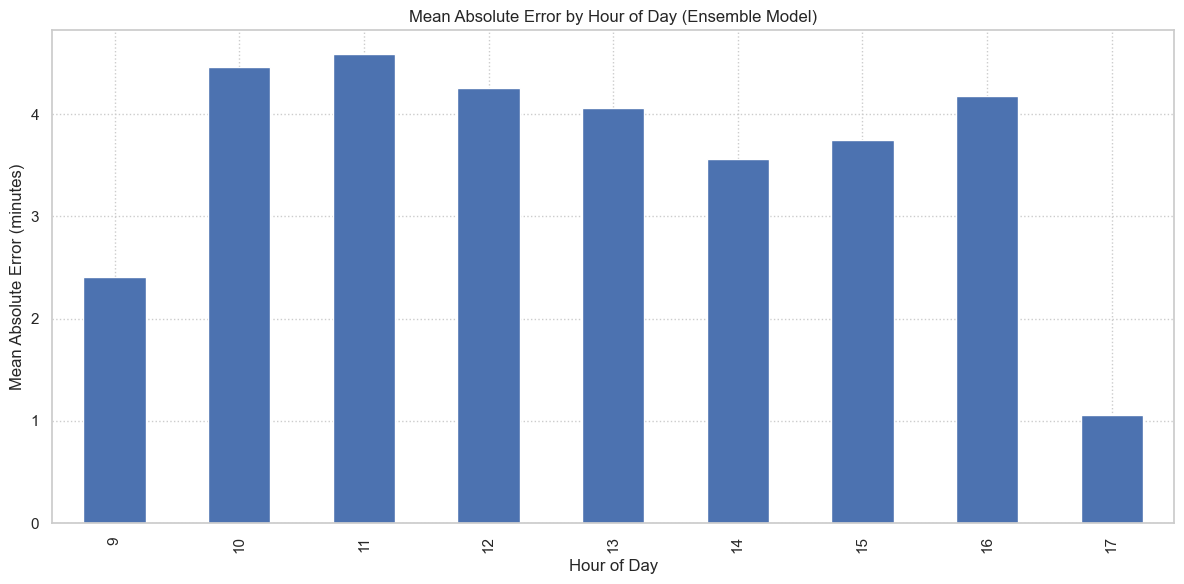

C:\Users\Nevin\AppData\Local\Temp\ipykernel_34300\1340702929.py:103: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_abs_errors = results_df.groupby('day').apply(lambda x: np.abs(x['Error']).mean())


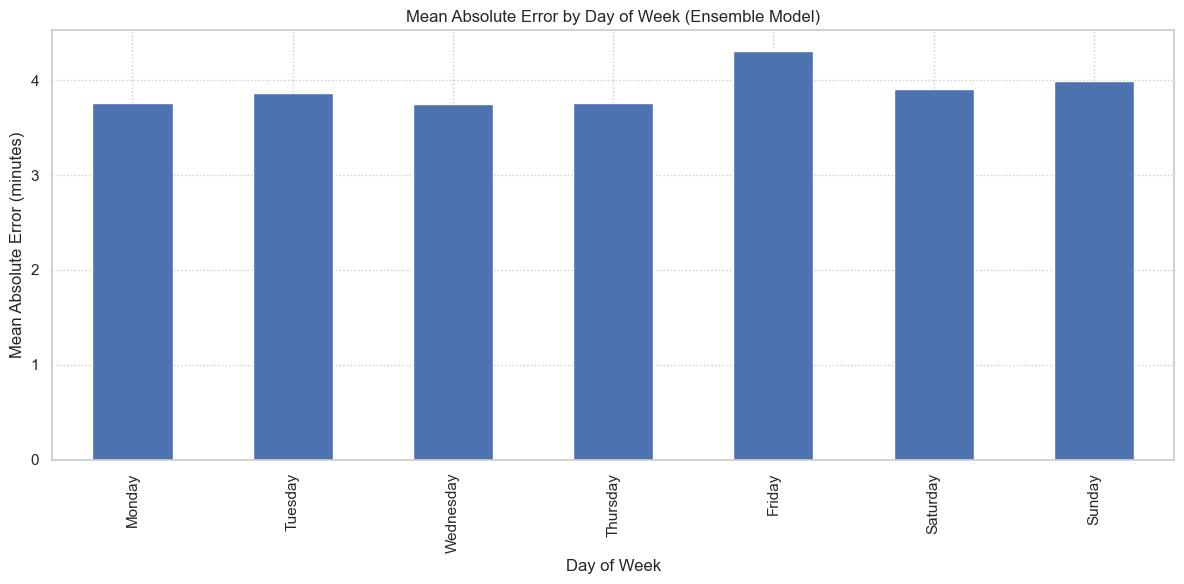

Traceback (most recent call last):



Best model based on MAE: Corrected GB
Identified 128 special dates (≥90.0th percentile):
  2017-05-25: High attendance day (96%): 43.0min avg wait
  2017-05-26: High attendance day (94%): 39.0min avg wait
  2017-05-27: High attendance day (98%): 47.8min avg wait
  2017-07-17: High attendance day (91%): 36.9min avg wait
  2017-07-22: High attendance day (99%): 53.8min avg wait
  2017-07-31: High attendance day (93%): 38.3min avg wait
  2017-08-02: High attendance day (91%): 37.0min avg wait
  2017-08-07: High attendance day (99%): 49.6min avg wait
  2017-08-09: High attendance day (92%): 37.9min avg wait
  2017-08-14: High attendance day (100%): 62.5min avg wait
  ... plus 118 more

Saved integrated model to models/poseidon_integrated_model.joblib

===== Demonstrating Future Wait Time Prediction for poseidon =====
Predicting attendance for future dates...
Starting feature preparation...
Input dataframe shape: (84, 41)
Total features selected: 33
Making wait time predictions...
Error an

  File "C:\Users\Nevin\AppData\Local\Temp\ipykernel_34300\1098225118.py", line 94, in <module>
    future_predictions = demo_future_prediction(ride_results, ride_name)
                         ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\Nevin\AppData\Local\Temp\ipykernel_34300\1098225118.py", line 47, in demo_future_prediction
    predictions = predict_future_wait_times(
                  ^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\Nevin\AppData\Local\Temp\ipykernel_34300\3650375753.py", line 101, in predict_future_wait_times
    predictions = apply_correction_model(primary_model, correction_model, feature_df)
                  ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\Nevin\AppData\Local\Temp\ipykernel_34300\2899288265.py", line 6, in apply_correction_model
    y_pred_primary = primary_model.predict(X_test)
                     ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Nevin\anaconda3\Lib\site-packages\sklearn\pipeli

In [35]:
def demo_future_prediction(models, ride_name):
    """
    Demonstrate future wait time prediction.
    
    Parameters:
    -----------
    models : dict
        Dictionary with trained models
    ride_name : str
        Name of the ride
    """
    print(f"\n===== Demonstrating Future Wait Time Prediction for {ride_name} =====")
    
    # Define future dates (next 7 days)
    today = datetime.today().date()
    future_dates = [today + timedelta(days=i) for i in range(7)]
    
    # Define hours to predict
    future_hours = list(range(9, 21))  # 9am to 8pm
    
    # Create simple weather forecast
    weather_forecast = {}
    for day_idx, d in enumerate(future_dates):
        # Simulate varying weather
        temp_base = 20 + day_idx % 3 * 2  # Range from 20-24°C
        rain = 0 if day_idx % 4 != 0 else 2  # Rain every 4th day
        wind = 5 + day_idx % 3 * 2  # Range from 5-9 mph
        
        weather_forecast[d] = {
            'temperature': temp_base,
            'temperature_mean': temp_base,
            'temperature_max': temp_base + 3,
            'temperature_min': temp_base - 2,
            'rain': rain * 0.5,
            'rain_sum': rain,
            'rain_max': rain * 1.5,
            'wind': wind,
            'wind_mean': wind,
            'wind_max': wind * 1.5
        }
    
    # Define holidays (if any)
    holidays = {}
    # Add holidays if needed
    
    # Make predictions
    predictions = predict_future_wait_times(
        future_dates,
        future_hours,
        models,
        weather_forecast=weather_forecast,
        holidays=holidays
    )
    
    print(f"Generated predictions for {len(predictions)} time slots")
    print("\nSample predictions:")
    print(predictions.head(10))
    
    # Visualize predictions
    visualize_future_predictions(predictions, title=f"Predicted Wait Times for {ride_name}")
    
    return predictions


if __name__ == "__main__":
    # Set plotting style
    plt.style.use('ggplot')
    sns.set(style="whitegrid")
    
    # Define parameters
    data_path = "../data/processed/ep/merged_with_holidays.parquet"  # Update with your actual path
    ride_names = ["silver star", "poseidon"]  # Update with your rides of interest
    test_year = 2023  # Year to use for testing
    
    # Process each ride
    results = {}
    
    for ride_name in ride_names:
        print(f"\n\n{'='*80}")
        print(f"ANALYZING RIDE: {ride_name.upper()}")
        print(f"{'='*80}\n")
        
        try:
            # Run the integrated pipeline
            ride_results = run_integrated_pipeline(
                file_path=data_path,
                ride_name=ride_name,
                test_year=test_year
            )
            
            results[ride_name] = ride_results
            
            # Demo future prediction
            future_predictions = demo_future_prediction(ride_results, ride_name)
            
            print(f"\nSuccessfully completed analysis for {ride_name}")
            print(f"Best model: {ride_results['best_model']}")
            
        except Exception as e:
            print(f"Error analyzing {ride_name}: {str(e)}")
            import traceback
            traceback.print_exc()
    
    # Print final summary
    if results:
        print("\n\n" + "="*80)
        print("FINAL SUMMARY")
        print("="*80)
        
        summary_data = []
        for ride_name, ride_results in results.items():
            metrics = ride_results['metrics']
            best_model = ride_results['best_model']
            best_mae = metrics.loc[best_model, 'MAE']
            best_rmse = metrics.loc[best_model, 'RMSE']
            best_r2 = metrics.loc[best_model, 'R²']
            
            summary_data.append({
                'Ride': ride_name,
                'Best Model': best_model,
                'MAE': best_mae,
                'RMSE': best_rmse,
                'R²': best_r2
            })
        
        summary_df = pd.DataFrame(summary_data)
        print("\nBest model performance for each ride:")
        print(summary_df)
    else:
        print("No results available to summarize.")